In [1]:
#create r-maps: pearson, spearman; n-map, thresholding, cross-validations

In [1]:
from nilearn import image
from nilearn.maskers import NiftiMasker
from scipy import stats
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import nibabel as nib
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt

# Make Matrix From All Subjects

In [13]:
#load subject matrix
def load_matrix():
    data = loadmat('/Volumes/Empty/Sweetspot_Seg/subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Empty/Sweetspot_Seg/Outputs/binary/zones1-2/binary_zones1-2_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection = first_matrix.copy(),df_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes cohorts
    cingulotomy_df = df_selection[cingulotomy_rows]
    cap_sct_df = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df

df = pd.read_csv('/Volumes/Empty/Sweetspot_Seg/All_YBOCS_Flip.csv')
df_array = df['Absolute'].to_numpy().reshape(-1, 1) #change for absolute vs relative

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df = matrix_df_selection(first_matrix,df_array)

In [3]:
#make matrix out of subjects using the binary n-map mask
def make_matrix(mask,path):
    nifti_masker = NiftiMasker(mask_img=mask)
    fmri_masked = nifti_masker.fit_transform(path)
    print('finished')
    return nifti_masker, fmri_masked

path = glob.glob(os.path.join('/Volumes/Empty/Sweetspot_Seg/Sweetspot_Seg_All_Flipped/Weighted_50-100/Efields_Masked_1.5','*.nii'))
mask = '/Volumes/Empty/Sweetspot_Seg/Outputs/binary/zones1-2/binary_zones1-2_n-map.nii.gz'

mask_nii,first_matrix = make_matrix(mask,path)

finished


# Cross Validations

In [14]:
def sweetspot(matrix):
    #pearson and spearman correlations of matrix and clinical outcomes
    def correlations(A, B,path,export=False):
        n = A.shape[1]
        dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        v_pear_r, v_pear_p, v_spear_r, v_spear_p = None, None, None, None
        A[np.isnan(A)],B[np.isnan(B)] = 0,0 #make nans 0
        if corr_type == 'pearson' or corr_type == 'both':
            A_mA = A - A.mean(1)[:, None]
            B_mB = B - B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            v_pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
            v_pear_p = 2*dist.cdf(-abs(v_pear_r))
            v_pear_p = np.around(v_pear_p, 200)
            v_pear_r[np.isnan(v_pear_r)],v_pear_p[np.isnan(v_pear_p)] = 0,0 #replace nans with 0s
            pos_v_pear_r = v_pear_r.copy()
            pos_v_pear_r[pos_v_pear_r < 0] = 0
        if corr_type == 'spearman' or corr_type == 'both':
            rank_A = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, A) #ranking
            rank_B = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, B)
            A_mA = rank_A - rank_A.mean(1)[:, None]
            B_mB = rank_B - rank_B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            v_spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()
            v_spear_p = 2 * dist.cdf(-np.abs(v_spear_r))
            v_spear_p = np.around(v_spear_p, 200)
            v_spear_r[np.isnan(v_spear_r)],v_spear_p[np.isnan(v_spear_p)] = 0,0 #replace nans with 0s
            pos_v_spear_r = v_spear_r.copy()
            pos_v_spear_r[pos_v_spear_r < 0] = 0
        
        if export:
            if corr_type == 'pearson' or corr_type == 'both':
                nib.save(mask_nii.inverse_transform(v_pear_r.reshape(1, -1)), f'{path}/pearson_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(v_pear_p.reshape(1, -1)), f'{path}/pearson_p-map_from_r.nii.gz'),nib.save(mask_nii.inverse_transform(pos_v_pear_r.reshape(1, -1)), f'{path}/positive_pearson_r-map.nii.gz')
            if corr_type == 'spearman' or corr_type == 'both':
                nib.save(mask_nii.inverse_transform(v_spear_r.reshape(1, -1)), f'{path}/spearman_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(v_spear_p.reshape(1, -1)), f'{path}/spearman_p-map_from_r.nii.gz'),nib.save(mask_nii.inverse_transform(pos_v_spear_r.reshape(1, -1)), f'{path}/positive_spearman_r-map.nii.gz')
        return v_pear_r,v_pear_p,pos_v_pear_r,v_spear_r,v_spear_p,pos_v_spear_r

    #make r and p maps only where significant p < 0.05
    def significant(path, corr_type, v_pear_r, v_pear_p, v_spear_r, v_spear_p, export=False):
        sig_pearson_r_map, sig_pearson_p_map, sig_spearman_r_map, sig_spearman_p_map = None, None, None, None
        if corr_type == 'pearson' or corr_type == 'both':
            sig_pearson_mask = (v_pear_p > 0) & (v_pear_p <= 0.05)
            sig_pearson_r_map = v_pear_r * sig_pearson_mask
            sig_pearson_p_map = v_pear_p * sig_pearson_mask
            pos_sig_pearson_r = sig_pearson_r_map.copy()
            pos_sig_pearson_r[pos_sig_pearson_r < 0] = 0
            if export:
                nib.save(mask_nii.inverse_transform(sig_pearson_r_map.reshape(1, -1)), f'{path}/pearson_sig_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(sig_pearson_p_map.reshape(1, -1)), f'{path}/pearson_sig_p-map.nii.gz'),nib.save(mask_nii.inverse_transform(pos_sig_pearson_r.reshape(1, -1)), f'{path}/positive_pearson_sig_r-map.nii.gz')
      
        if corr_type == 'spearman' or corr_type == 'both':
            sig_spearman_mask = (v_spear_p > 0) & (v_spear_p <= 0.05)
            sig_spearman_r_map = v_spear_r * sig_spearman_mask
            sig_spearman_p_map = v_spear_p * sig_spearman_mask
            pos_sig_spearman_r = sig_spearman_r_map.copy()
            pos_sig_spearman_r[pos_sig_spearman_r < 0] = 0
            if export:
                nib.save(mask_nii.inverse_transform(sig_spearman_r_map.reshape(1, -1)), f'{path}/spearman_sig_r-map.nii.gz'),nib.save(mask_nii.inverse_transform(sig_spearman_p_map.reshape(1, -1)), f'{path}/spearman_sig_p-map.nii.gz'),nib.save(mask_nii.inverse_transform(pos_sig_spearman_r.reshape(1, -1)), f'{path}/positive_spearman_sig_r-map.nii.gz')
        return sig_pearson_r_map, sig_pearson_p_map,pos_sig_pearson_r, sig_spearman_r_map, sig_spearman_p_map,pos_sig_spearman_r

    #n-map
    def n_map(matrix, path, export=False):
        n_matrix = matrix.copy()
        n_matrix[n_matrix != 0] = 1
        sum_vector = np.sum(n_matrix, axis=0)
        sum_vector_reshape = sum_vector.reshape(1, -1)
        if export:
            nib.save(mask_nii.inverse_transform(sum_vector_reshape[0]), f'{path}/n-map.nii.gz')
        return sum_vector

    #threshold n-map by desired amount
    def threshold_n(sum_vector,path, threshold, export=False,v_pear_r=None):
        thresholded_vector = sum_vector.copy()
        thresholded_vector[thresholded_vector <= threshold] = 0
        thresholded_vector_reshape = thresholded_vector.reshape(1, -1)  
        if export:
            nib.save(mask_nii.inverse_transform(thresholded_vector_reshape[0]), f'{path}/n-map_thresholded_by_{threshold}.nii.gz')
        return thresholded_vector

    #threshold r-maps to designated threshold of n-map
    def threshold_r_p(thresholded_vector, path, threshold, v_pear_r, v_pear_p, sig_pearson_r_map, sig_pearson_p_map, v_spear_r, v_spear_p, sig_spearman_r_map, sig_spearman_p_map, corr_type, export):
        binary_threshold_n_vector = thresholded_vector.copy()
        binary_threshold_n_vector[binary_threshold_n_vector > 0] = 1
        if corr_type == 'pearson' or corr_type == 'both':
            thresholded_pearson_sig_r_map = sig_pearson_r_map * binary_threshold_n_vector
            thresholded_pearson_sig_p_map = sig_pearson_p_map * binary_threshold_n_vector
            thresholded_pearson_r_map = v_pear_r * binary_threshold_n_vector
            thresholded_pearson_p_map = v_pear_p * binary_threshold_n_vector
            positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map = thresholded_pearson_r_map.copy(),thresholded_pearson_sig_r_map.copy()
            positive_thresholded_pearson_r_map[positive_thresholded_pearson_r_map < 0] = 0 #make all neg values = 0
            positive_thresholded_pearson_sig_r_map[positive_thresholded_pearson_sig_r_map < 0] = 0 #make all neg values = 0
            if export:
                nib.save(mask_nii.inverse_transform(thresholded_pearson_sig_r_map.reshape(1, -1)), f'{path}/sig_pearson_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_sig_p_map.reshape(1, -1)), f'{path}/sig_pearson_p-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_r_map.reshape(1, -1)), f'{path}/pearson_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_pearson_p_map.reshape(1, -1)), f'{path}/pearson_p-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_pearson_sig_r_map.reshape(1, -1)), f'{path}/positive_sig_pearson_r-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_pearson_sig_r_map.reshape(1, -1)), f'{path}/positive_sig_pearson_r-map_thresholded_by_{threshold}.nii.gz')
       
        if corr_type == 'spearman' or corr_type == 'both':
            thresholded_spearman_sig_r_map = sig_spearman_r_map * binary_threshold_n_vector
            thresholded_spearman_sig_p_map = sig_spearman_p_map * binary_threshold_n_vector
            thresholded_spearman_r_map = v_spear_r * binary_threshold_n_vector
            thresholded_spearman_p_map = v_spear_p * binary_threshold_n_vector
            positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map = thresholded_spearman_r_map.copy(),thresholded_spearman_sig_r_map.copy()
            positive_thresholded_spearman_r_map[positive_thresholded_spearman_r_map < 0] = 0 #make all neg values = 0
            positive_thresholded_spearman_sig_r_map[positive_thresholded_spearman_sig_r_map < 0] = 0 #make all neg values = 0
            
            if export:
                nib.save(mask_nii.inverse_transform(thresholded_spearman_sig_r_map.reshape(1, -1)), f'{path}/sig_spearman_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_sig_p_map.reshape(1, -1)), f'{path}/sig_spearman_p-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_r_map.reshape(1, -1)), f'{path}/spearman_r-map_thresholded_by_{threshold}.nii.gz'), nib.save(mask_nii.inverse_transform(thresholded_spearman_p_map.reshape(1, -1)), f'{path}/spearman_p-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_spearman_sig_r_map.reshape(1, -1)), f'{path}/positive_spearman_r-map_thresholded_by_{threshold}.nii.gz'),nib.save(mask_nii.inverse_transform(positive_thresholded_spearman_sig_r_map.reshape(1, -1)), f'{path}/positive_sig_spearman_r-map_thresholded_by_{threshold}.nii.gz')
        return thresholded_pearson_r_map, thresholded_pearson_sig_r_map, thresholded_pearson_p_map, thresholded_pearson_sig_p_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map, thresholded_spearman_p_map, thresholded_spearman_sig_p_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map

    path = '/Volumes/Empty/Sweetspot_Seg/Outputs/matrix_tests' #path to export to
    export = False
    corr_type = 'both' #change for correlation type: pearson, spearman, or both
    threshold = 5 #n-threshold, greater than or equal to

    matrix = cap_sct_matrix #cingulotomy_matrix or cap_sct_matrix
    df = cap_sct_df #cingulotomy_df or cap_sct_df
    
    vector_pearson_correlation_coefficients, vector_pearson_p_values, positive_pearson_r_values, vector_spearman_correlation_coefficients, vector_spearman_p_values,positive_spearman_r_values = correlations(matrix.T, df.T, path, export)
    significant_pearson_correlation_coefficients, significant_pearson_p_values, positive_significant_pearson_correlation_coefficients, significant_spearman_correlation_coefficients, significant_spearman_p_values,positive_significant_spearman_correlation_coefficients = significant(path, corr_type, vector_pearson_correlation_coefficients, vector_pearson_p_values, vector_spearman_correlation_coefficients, vector_spearman_p_values, export)
    n_vector = n_map(matrix, path, export)
    threshold_n_result = threshold_n(n_vector, path, threshold, export, v_pear_r = vector_pearson_correlation_coefficients)
    thresholded_pearson_r_map, thresholded_pearson_sig_r_map, thresholded_pearson_p_map, thresholded_pearson_sig_p_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map, thresholded_spearman_p_map, thresholded_spearman_sig_p_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map = threshold_r_p(threshold_n_result, path, threshold, vector_pearson_correlation_coefficients, vector_pearson_p_values, significant_pearson_correlation_coefficients, significant_pearson_p_values, vector_spearman_correlation_coefficients, vector_spearman_p_values, significant_spearman_correlation_coefficients, significant_spearman_p_values, corr_type, export)

    return vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map,thresholded_pearson_sig_r_map, positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map

#get overlap and r & p values
def sweetspot_score(corr_type,matrix,df_column,vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map, positive_thresholded_pearson_r_map,thresholded_pearson_sig_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map):
    efield_matrix = matrix.copy()
    if corr_type == 'pearson' or corr_type == 'both':
        #make empty matricies to store outputs in
        pearson_sweetspot_score,pos_pearson_sweetspot_score,sig_pearson_sweetspot_score,pos_sig_pearson_sweetspot_score,thresholded_pearson_sweetspot_score,pos_thresholded_pearson_sweetspot_score,thresholded_sig_pearson_sweetspot_score,pos_thresholded_sig_pearson_sweetspot_score = np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0]))
        pearson_sweetspot_corr,pos_pearson_sweetspot_corr,sig_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,thresholded_pearson_sweetspot_corr,pos_thresholded_pearson_sweetspot_corr,thresholded_sig_pearson_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_corr = np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0]))

        for i in range(efield_matrix.shape[0]):
            #multiply voxels together in subject efield and r-map and then average the row together            
            pearson_sweetspot_score[i],pos_pearson_sweetspot_score[i],sig_pearson_sweetspot_score[i],pos_sig_pearson_sweetspot_score[i],thresholded_pearson_sweetspot_score[i],pos_thresholded_pearson_sweetspot_score[i],thresholded_sig_pearson_sweetspot_score[i],pos_thresholded_sig_pearson_sweetspot_score[i] = np.mean(np.multiply(vector_pearson_correlation_coefficients[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_pearson_r_values[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(significant_pearson_correlation_coefficients[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_significant_pearson_correlation_coefficients[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(thresholded_pearson_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_thresholded_pearson_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(thresholded_pearson_sig_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_thresholded_pearson_sig_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))

            #correlate clinical outcomes with sweetspot_score
            pearson_sweetspot_corr[i],p = pearsonr(pearson_sweetspot_score,df_column)
            sig_pearson_sweetspot_corr[i],p = pearsonr(sig_pearson_sweetspot_score,df_column)
            thresholded_pearson_sweetspot_corr[i],p = pearsonr(thresholded_pearson_sweetspot_score,df_column)
            thresholded_sig_pearson_sweetspot_corr[i],p = pearsonr(thresholded_sig_pearson_sweetspot_score,df_column)
            
            pos_pearson_sweetspot_corr[i],p = pearsonr(pos_pearson_sweetspot_score,df_column)
            pos_sig_pearson_sweetspot_corr[i],p = pearsonr(pos_sig_pearson_sweetspot_score,df_column)
            pos_thresholded_pearson_sweetspot_corr[i],p = pearsonr(pos_thresholded_pearson_sweetspot_score,df_column)
            pos_thresholded_sig_pearson_sweetspot_corr[i],p = pearsonr(pos_thresholded_sig_pearson_sweetspot_score,df_column)
            
        #overall r and p values
        pearson_r_val,pearson_p_val = pearsonr(pearson_sweetspot_corr,df_column)
        sig_pearson_r_val,sig_pearson_p_val = pearsonr(sig_pearson_sweetspot_corr,df_column)
        thresholded_pearson_r_val,thresholded_pearson_p_val = pearsonr(thresholded_pearson_sweetspot_corr,df_column)
        thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val = pearsonr(thresholded_sig_pearson_sweetspot_corr,df_column)
        
        s_pearson_r_val,s_pearson_p_val = spearmanr(pearson_sweetspot_corr,df_column)
        s_sig_pearson_r_val,s_sig_pearson_p_val = spearmanr(sig_pearson_sweetspot_corr,df_column)
        s_thresholded_pearson_r_val,s_thresholded_pearson_p_val = spearmanr(thresholded_pearson_sweetspot_corr,df_column)
        s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val = spearmanr(thresholded_sig_pearson_sweetspot_corr,df_column)

        pos_pearson_r_val,pos_pearson_p_val = pearsonr(pos_pearson_sweetspot_corr,df_column)
        pos_sig_pearson_r_val,pos_sig_pearson_p_val = pearsonr(pos_sig_pearson_sweetspot_corr,df_column)
        pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val = pearsonr(pos_thresholded_pearson_sweetspot_corr,df_column)
        pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val = pearsonr(pos_thresholded_sig_pearson_sweetspot_corr,df_column)
        pos_s_pearson_r_val,pos_s_pearson_p_val = spearmanr(pos_pearson_sweetspot_corr,df_column)
        pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val = spearmanr(pos_sig_pearson_sweetspot_corr,df_column)
        pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val = spearmanr(pos_thresholded_pearson_sweetspot_corr,df_column)
        pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val = spearmanr(pos_thresholded_sig_pearson_sweetspot_corr,df_column)
        
    if corr_type == 'spearman' or corr_type == 'both':
        #make empty matricies to store outputs in
        spearman_sweetspot_score,sig_spearman_sweetspot_score,thresholded_spearman_sweetspot_score,thresholded_sig_spearman_sweetspot_score,pos_spearman_sweetspot_score,pos_sig_spearman_sweetspot_score,pos_thresholded_spearman_sweetspot_score,pos_thresholded_sig_spearman_sweetspot_score = np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0])
        spearman_sweetspot_corr,sig_spearman_sweetspot_corr,thresholded_spearman_sweetspot_corr,thresholded_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,pos_thresholded_spearman_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr = np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0])

        for i in range(efield_matrix.shape[0]): 
            #multiply voxels together in subject efield and r-map and then average the row together            
            spearman_sweetspot_score[i],pos_spearman_sweetspot_score[i],sig_spearman_sweetspot_score[i],pos_sig_spearman_sweetspot_score[i],thresholded_spearman_sweetspot_score[i],pos_thresholded_spearman_sweetspot_score[i],thresholded_sig_spearman_sweetspot_score[i],pos_thresholded_sig_spearman_sweetspot_score[i] = np.mean(np.multiply(vector_spearman_correlation_coefficients[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_spearman_r_values[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(significant_spearman_correlation_coefficients[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_significant_spearman_correlation_coefficients[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(thresholded_spearman_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_thresholded_spearman_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(thresholded_spearman_sig_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0])),np.mean(np.multiply(positive_thresholded_spearman_sig_r_map[efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
            
            #correlate clinical outcomes with sweetspot_score
            spearman_sweetspot_corr[i],p = spearmanr(spearman_sweetspot_score,df_column)
            sig_spearman_sweetspot_corr[i],p = spearmanr(sig_spearman_sweetspot_score,df_column)
            thresholded_spearman_sweetspot_corr[i],p = spearmanr(thresholded_spearman_sweetspot_score,df_column)
            thresholded_sig_spearman_sweetspot_corr[i],p = spearmanr(thresholded_sig_spearman_sweetspot_score,df_column)

            pos_spearman_sweetspot_corr[i],p = spearmanr(pos_spearman_sweetspot_score,df_column)
            pos_sig_spearman_sweetspot_corr[i],p = spearmanr(pos_sig_spearman_sweetspot_score,df_column)
            pos_thresholded_spearman_sweetspot_corr[i],p = spearmanr(pos_thresholded_spearman_sweetspot_score,df_column)
            pos_thresholded_sig_spearman_sweetspot_corr[i],p = spearmanr(pos_thresholded_sig_spearman_sweetspot_score,df_column)
            
        #overall r and p values
        spearman_r_val,spearman_p_val = spearmanr(spearman_sweetspot_corr,df_column)
        sig_spearman_r_val,sig_spearman_p_val = spearmanr(sig_spearman_sweetspot_corr,df_column)
        thresholded_spearman_r_val,thresholded_spearman_p_val = spearmanr(thresholded_spearman_sweetspot_corr,df_column)
        thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val = spearmanr(thresholded_sig_spearman_sweetspot_corr,df_column)
        p_spearman_r_val,p_spearman_p_val = pearsonr(spearman_sweetspot_corr,df_column)
        p_sig_spearman_r_val,p_sig_spearman_p_val = pearsonr(sig_spearman_sweetspot_corr,df_column)
        p_thresholded_spearman_r_val,p_thresholded_spearman_p_val = pearsonr(thresholded_spearman_sweetspot_corr,df_column)
        p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val = pearsonr(thresholded_sig_spearman_sweetspot_corr,df_column)
    
        pos_spearman_r_val,pos_spearman_p_val = spearmanr(pos_spearman_sweetspot_corr,df_column)
        pos_sig_spearman_r_val,pos_sig_spearman_p_val = spearmanr(pos_sig_spearman_sweetspot_corr,df_column)
        pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val = spearmanr(pos_thresholded_spearman_sweetspot_corr,df_column)
        pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val = spearmanr(pos_thresholded_sig_spearman_sweetspot_corr,df_column)
        pos_p_spearman_r_val,pos_p_spearman_p_val = pearsonr(pos_spearman_sweetspot_corr,df_column)
        pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val = pearsonr(pos_sig_spearman_sweetspot_corr,df_column)
        pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val = pearsonr(pos_thresholded_spearman_sweetspot_corr,df_column)
        pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val = pearsonr(pos_thresholded_sig_spearman_sweetspot_corr,df_column)
    
    return pearson_sweetspot_corr,sig_pearson_sweetspot_corr,thresholded_pearson_sweetspot_corr,thresholded_sig_pearson_sweetspot_corr, pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,pos_thresholded_pearson_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_corr,spearman_sweetspot_corr,sig_spearman_sweetspot_corr,thresholded_spearman_sweetspot_corr,thresholded_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,pos_thresholded_spearman_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val
    
matrix = cap_sct_matrix #cingulotomy_matrix or cap_sct_matrix
df_column = cap_sct_df.flatten() #cingulotomy_df or cap_sct_df
corr_type = 'both' #change for correlation type: pearson, spearman, or both

def cross_validations(matrix):
    num_sub = matrix.shape[0]
    for i in range(num_sub):
        print(f'Iteration: {i + 1}/{num_sub}')
        current_subject_matrix = np.delete(matrix, i, axis=1) #exclude the i-th subject
        outputs = sweetspot(current_subject_matrix) #call sweetspot function with the modified subject matrix
        #unpack outputs for the sweetspot_score function
        vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map, thresholded_pearson_sig_r_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map = outputs
        #call sweetspot_score with the obtained outputs
        pearson_sweetspot_corr,sig_pearson_sweetspot_corr,thresholded_pearson_sweetspot_corr,thresholded_sig_pearson_sweetspot_corr, pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,pos_thresholded_pearson_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_corr,spearman_sweetspot_corr,sig_spearman_sweetspot_corr,thresholded_spearman_sweetspot_corr,thresholded_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,pos_thresholded_spearman_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val = sweetspot_score(corr_type,matrix,df_column,vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map, positive_thresholded_pearson_r_map,thresholded_pearson_sig_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map)
    return (pearson_sweetspot_corr,sig_pearson_sweetspot_corr,thresholded_pearson_sweetspot_corr,thresholded_sig_pearson_sweetspot_corr, pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,pos_thresholded_pearson_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_corr,spearman_sweetspot_corr,sig_spearman_sweetspot_corr,thresholded_spearman_sweetspot_corr,thresholded_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,pos_thresholded_spearman_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val)

matrix = cap_sct_matrix #cingulotomy_matrix or cap_sct_matrix

(vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map, thresholded_pearson_sig_r_map,positive_thresholded_pearson_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map) = sweetspot(matrix)
(pearson_sweetspot_corr,sig_pearson_sweetspot_corr,thresholded_pearson_sweetspot_corr,thresholded_sig_pearson_sweetspot_corr, pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,pos_thresholded_pearson_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_corr,spearman_sweetspot_corr,sig_spearman_sweetspot_corr,thresholded_spearman_sweetspot_corr,thresholded_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,pos_thresholded_spearman_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val) = sweetspot_score(corr_type,matrix,df_column,vector_pearson_correlation_coefficients,positive_pearson_r_values,significant_pearson_correlation_coefficients,positive_significant_pearson_correlation_coefficients,vector_spearman_correlation_coefficients,positive_spearman_r_values, significant_spearman_correlation_coefficients, positive_significant_spearman_correlation_coefficients,thresholded_pearson_r_map, positive_thresholded_pearson_r_map,thresholded_pearson_sig_r_map,positive_thresholded_pearson_sig_r_map, thresholded_spearman_r_map, thresholded_spearman_sig_r_map,positive_thresholded_spearman_r_map,positive_thresholded_spearman_sig_r_map)
(pearson_sweetspot_corr,sig_pearson_sweetspot_corr,thresholded_pearson_sweetspot_corr,thresholded_sig_pearson_sweetspot_corr, pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,pos_thresholded_pearson_sweetspot_corr,pos_thresholded_sig_pearson_sweetspot_corr,spearman_sweetspot_corr,sig_spearman_sweetspot_corr,thresholded_spearman_sweetspot_corr,thresholded_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,pos_thresholded_spearman_sweetspot_corr,pos_thresholded_sig_spearman_sweetspot_corr,pearson_r_val,pearson_p_val,sig_pearson_r_val,sig_pearson_p_val,thresholded_pearson_r_val,thresholded_pearson_p_val,thresholded_sig_pearson_r_val,thresholded_sig_pearson_p_val,s_pearson_r_val,s_pearson_p_val,s_sig_pearson_r_val,s_sig_pearson_p_val,s_thresholded_pearson_r_val,s_thresholded_pearson_p_val,s_thresholded_sig_pearson_r_val,s_thresholded_sig_pearson_p_val,spearman_r_val,spearman_p_val,sig_spearman_r_val,sig_spearman_p_val,thresholded_spearman_r_val,thresholded_spearman_p_val,thresholded_sig_spearman_r_val,thresholded_sig_spearman_p_val,p_spearman_r_val,p_spearman_p_val,p_sig_spearman_r_val,p_sig_spearman_p_val,p_thresholded_spearman_r_val,p_thresholded_spearman_p_val,p_thresholded_sig_spearman_r_val,p_thresholded_sig_spearman_p_val,pos_pearson_r_val,pos_pearson_p_val,pos_sig_pearson_r_val,pos_sig_pearson_p_val,pos_thresholded_pearson_r_val,pos_thresholded_pearson_p_val,pos_thresholded_sig_pearson_r_val,pos_thresholded_sig_pearson_p_val,pos_s_pearson_r_val,pos_s_pearson_p_val,pos_s_sig_pearson_r_val,pos_s_sig_pearson_p_val,pos_s_thresholded_pearson_r_val,pos_s_thresholded_pearson_p_val,pos_s_thresholded_sig_pearson_r_val,pos_s_thresholded_sig_pearson_p_val,pos_spearman_r_val,pos_spearman_p_val,pos_sig_spearman_r_val,pos_sig_spearman_p_val,pos_thresholded_spearman_r_val,pos_thresholded_spearman_p_val,pos_thresholded_sig_spearman_r_val,pos_thresholded_sig_spearman_p_val,pos_p_spearman_r_val,pos_p_spearman_p_val,pos_p_sig_spearman_r_val,pos_p_sig_spearman_p_val,pos_p_thresholded_spearman_r_val,pos_p_thresholded_spearman_p_val,pos_p_thresholded_sig_spearman_r_val,pos_p_thresholded_sig_spearman_p_val) = cross_validations(matrix)

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_50140/1177322805.py:14: RuntimeWarning: invalid value encountered in divide
  v_pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_50140/1177322805.py:29: RuntimeWarning: invalid value encountered in divide
  v_spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()


Iteration: 1/34
Iteration: 2/34
Iteration: 3/34
Iteration: 4/34
Iteration: 5/34
Iteration: 6/34
Iteration: 7/34
Iteration: 8/34
Iteration: 9/34
Iteration: 10/34
Iteration: 11/34
Iteration: 12/34
Iteration: 13/34
Iteration: 14/34
Iteration: 15/34
Iteration: 16/34
Iteration: 17/34
Iteration: 18/34
Iteration: 19/34
Iteration: 20/34
Iteration: 21/34
Iteration: 22/34
Iteration: 23/34
Iteration: 24/34
Iteration: 25/34
Iteration: 26/34
Iteration: 27/34
Iteration: 28/34
Iteration: 29/34
Iteration: 30/34
Iteration: 31/34
Iteration: 32/34
Iteration: 33/34
Iteration: 34/34


# Cross-Validation Plots

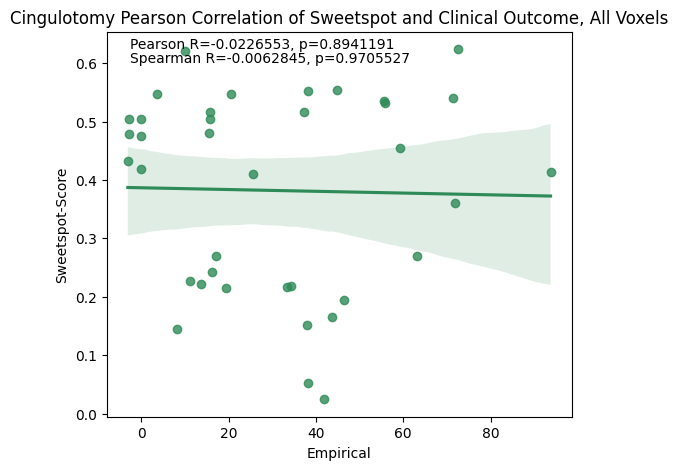

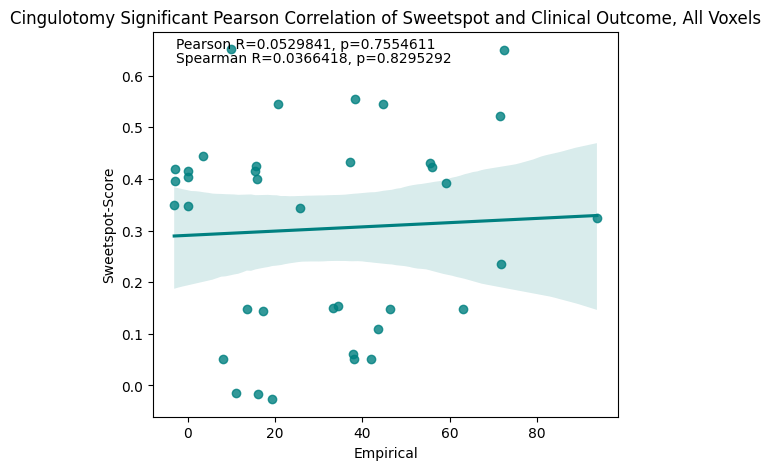

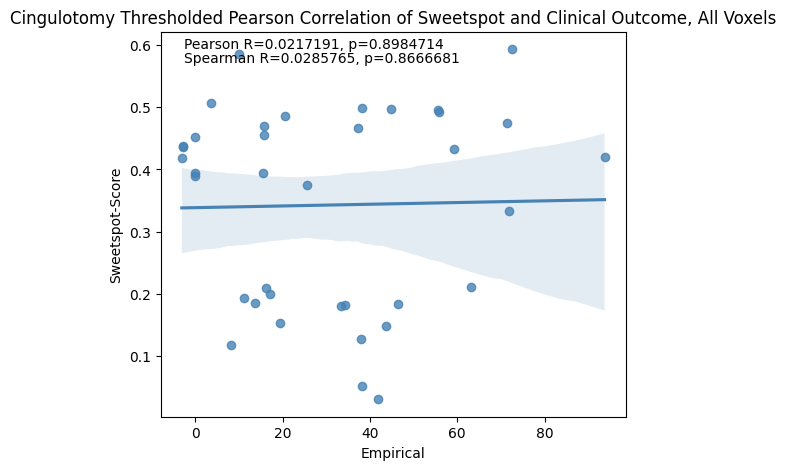

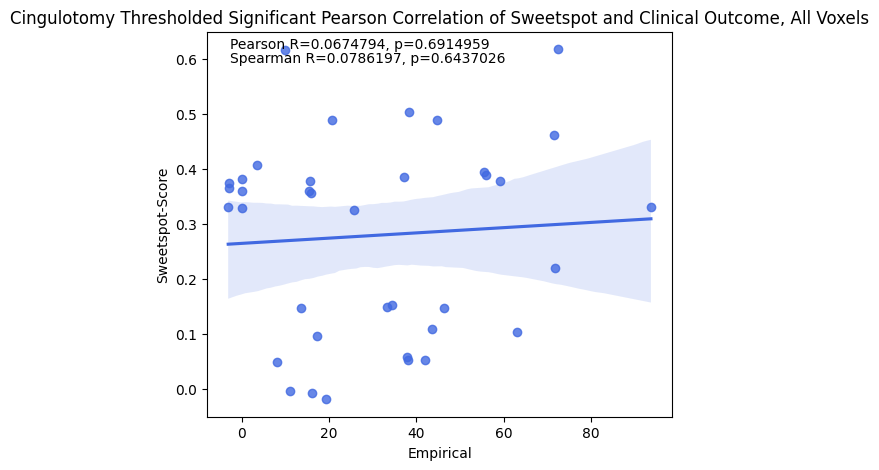

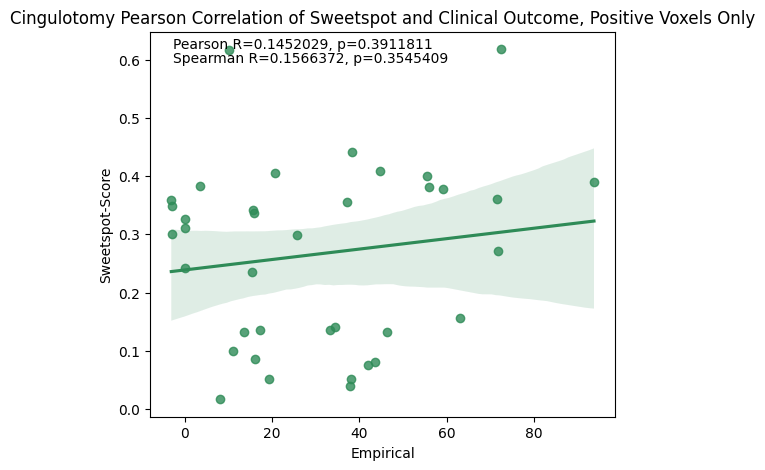

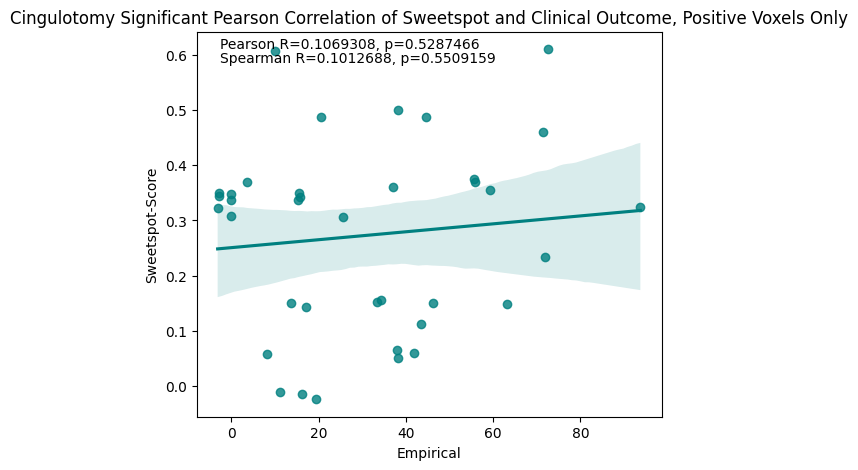

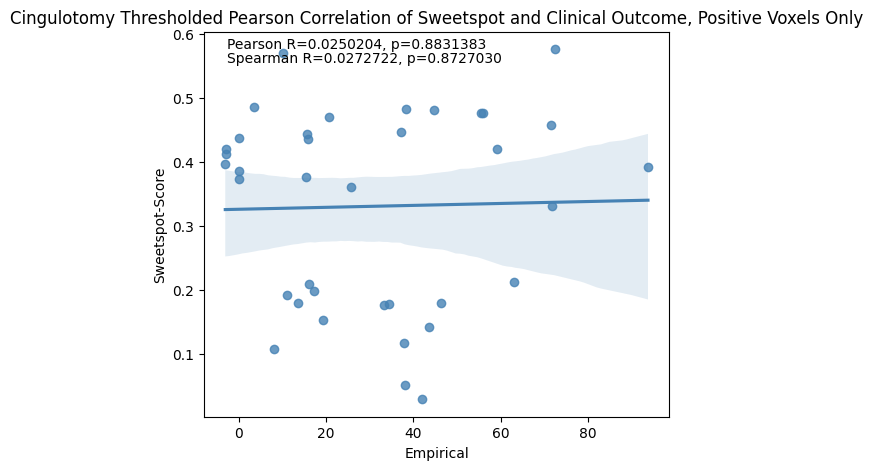

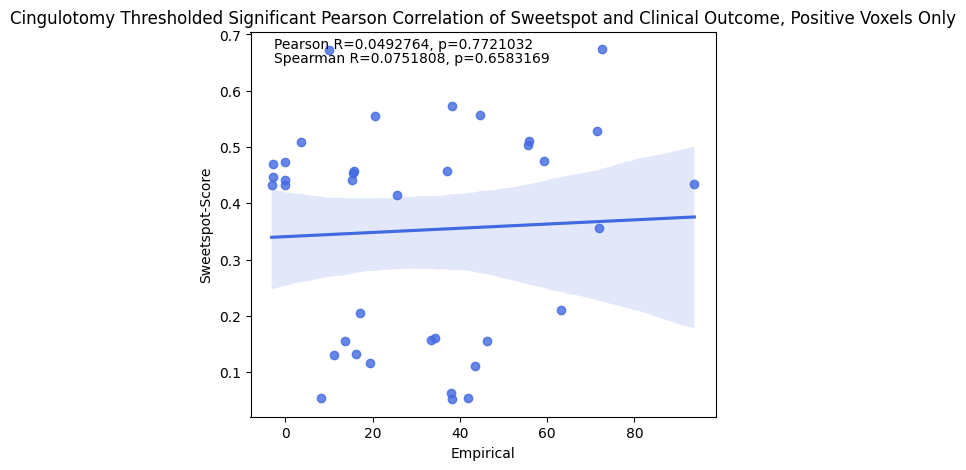

In [8]:
#pearson analysis for cingulotomies, relative
def plot_pearson_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_pearson_analysis(cingulotomy_df, pearson_sweetspot_corr, 'Cingulotomy Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels', pearson_r_val, pearson_p_val, s_pearson_r_val, s_pearson_p_val, 'seagreen')
plot_pearson_analysis(cingulotomy_df, sig_pearson_sweetspot_corr, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_pearson_r_val, sig_pearson_p_val, s_sig_pearson_r_val, s_sig_pearson_p_val, 'teal')
plot_pearson_analysis(cingulotomy_df, thresholded_pearson_sweetspot_corr, 'Cingulotomy Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_pearson_r_val, thresholded_pearson_p_val, s_thresholded_pearson_r_val, s_thresholded_pearson_p_val, 'steelblue')
plot_pearson_analysis(cingulotomy_df, thresholded_sig_pearson_sweetspot_corr, 'Cingulotomy Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_sig_pearson_r_val, thresholded_sig_pearson_p_val, s_thresholded_sig_pearson_r_val, s_thresholded_sig_pearson_p_val, 'royalblue')

#positive
plot_pearson_analysis(cingulotomy_df, pos_pearson_sweetspot_corr, 'Cingulotomy Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_pearson_r_val, pos_pearson_p_val, pos_s_pearson_r_val, pos_s_pearson_p_val, 'seagreen')
plot_pearson_analysis(cingulotomy_df, pos_sig_pearson_sweetspot_corr, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_pearson_r_val, pos_sig_pearson_p_val, pos_s_sig_pearson_r_val, pos_s_sig_pearson_p_val, 'teal')
plot_pearson_analysis(cingulotomy_df, pos_thresholded_pearson_sweetspot_corr, 'Cingulotomy Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_pearson_r_val, pos_thresholded_pearson_p_val, pos_s_thresholded_pearson_r_val, pos_s_thresholded_pearson_p_val, 'steelblue')
plot_pearson_analysis(cingulotomy_df, pos_thresholded_sig_pearson_sweetspot_corr, 'Cingulotomy Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_pearson_r_val, pos_thresholded_sig_pearson_p_val, pos_s_thresholded_sig_pearson_r_val, pos_s_thresholded_sig_pearson_p_val, 'royalblue')

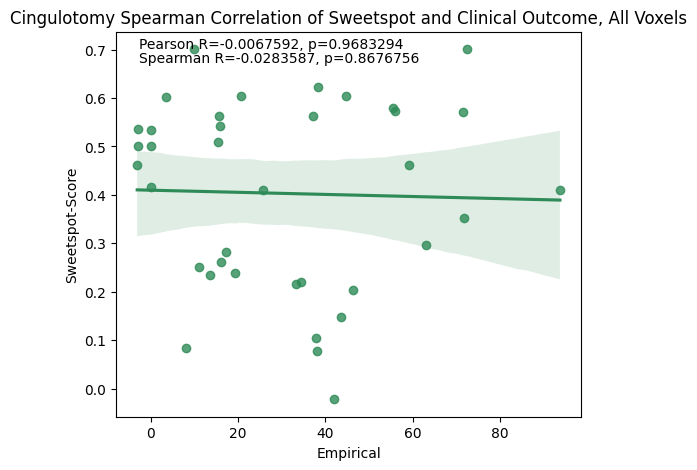

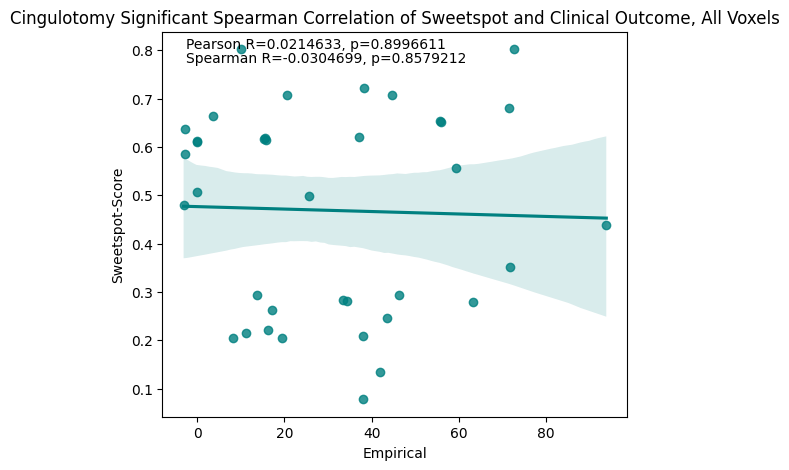

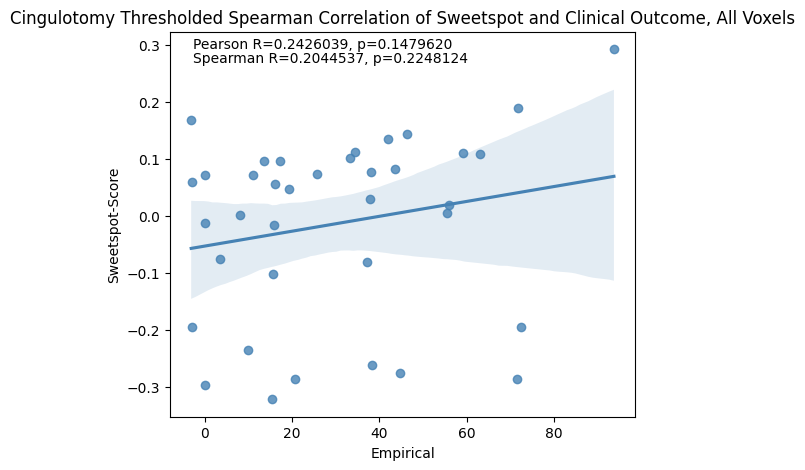

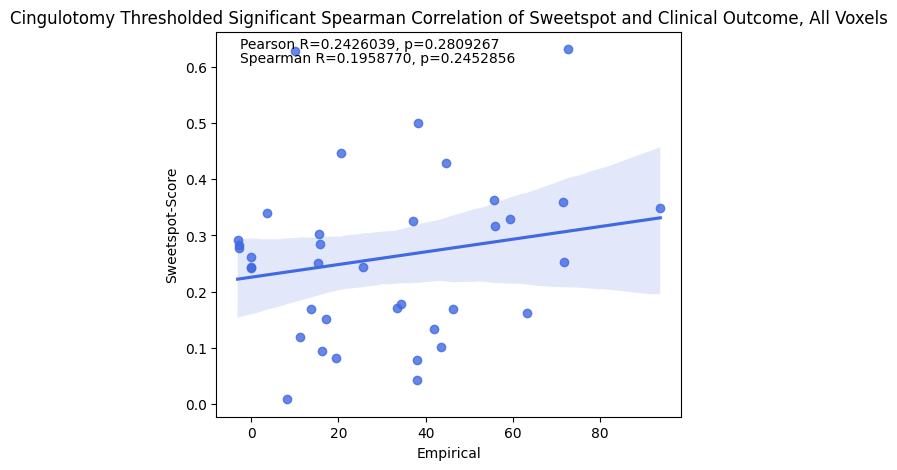

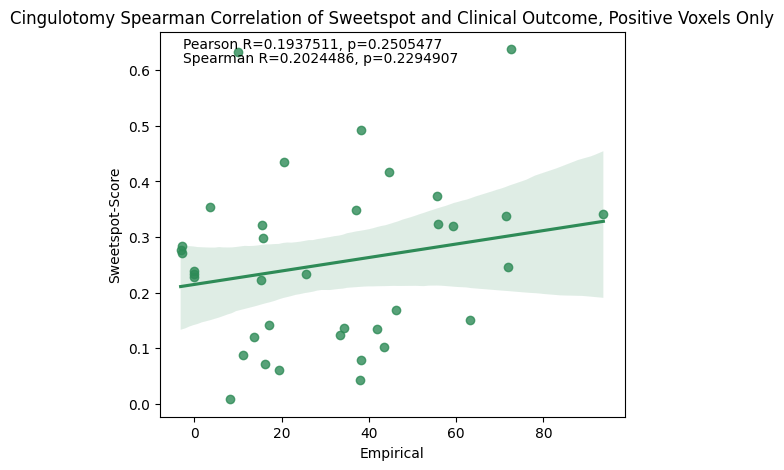

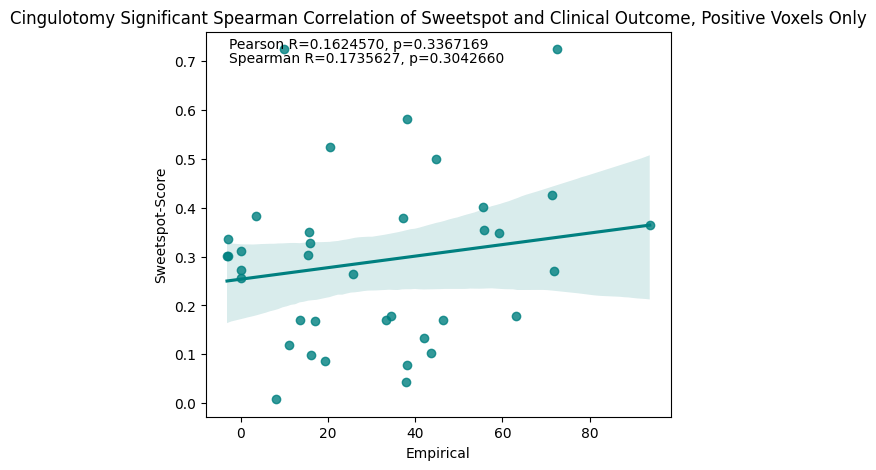

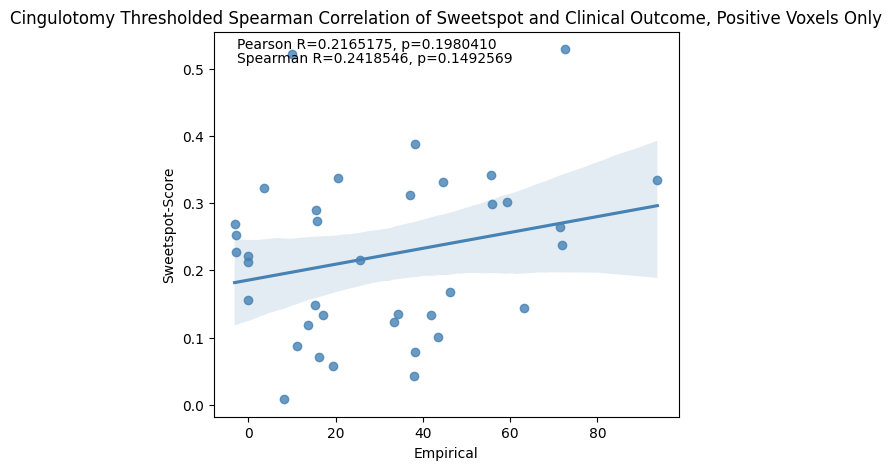

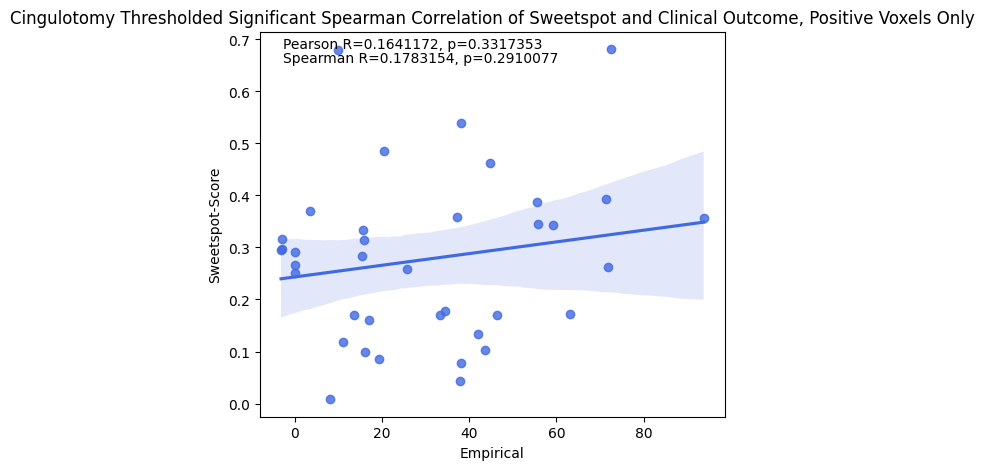

In [9]:
#spearman analysis for cingulotomies, relative
def plot_spearman_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_spearman_analysis(cingulotomy_df, spearman_sweetspot_corr, 'Cingulotomy Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels', spearman_r_val, spearman_p_val, p_spearman_r_val, p_spearman_p_val, 'seagreen')
plot_spearman_analysis(cingulotomy_df, sig_spearman_sweetspot_corr, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_spearman_r_val, sig_spearman_p_val, p_sig_spearman_r_val, p_sig_spearman_p_val, 'teal')
plot_spearman_analysis(cingulotomy_df, thresholded_spearman_sweetspot_corr, 'Cingulotomy Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_spearman_p_val, p_thresholded_spearman_r_val, p_thresholded_spearman_p_val, 'steelblue')
plot_spearman_analysis(cingulotomy_df, thresholded_sig_spearman_sweetspot_corr, 'Cingulotomy Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_sig_spearman_p_val, p_thresholded_sig_spearman_r_val, p_thresholded_sig_spearman_p_val, 'royalblue')

#positive voxels only
plot_spearman_analysis(cingulotomy_df, pos_spearman_sweetspot_corr, 'Cingulotomy Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_spearman_r_val, pos_spearman_p_val, pos_p_spearman_r_val, pos_p_spearman_p_val, 'seagreen')
plot_spearman_analysis(cingulotomy_df, pos_sig_spearman_sweetspot_corr, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_spearman_r_val, pos_sig_spearman_p_val, pos_p_sig_spearman_r_val, pos_p_sig_spearman_p_val, 'teal')
plot_spearman_analysis(cingulotomy_df, pos_thresholded_spearman_sweetspot_corr, 'Cingulotomy Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_spearman_r_val, pos_thresholded_spearman_p_val, pos_p_thresholded_spearman_r_val, pos_p_thresholded_spearman_p_val, 'steelblue')
plot_spearman_analysis(cingulotomy_df, pos_thresholded_sig_spearman_sweetspot_corr, 'Cingulotomy Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_spearman_r_val, pos_thresholded_sig_spearman_p_val, pos_p_thresholded_sig_spearman_r_val, pos_p_thresholded_sig_spearman_p_val, 'royalblue')

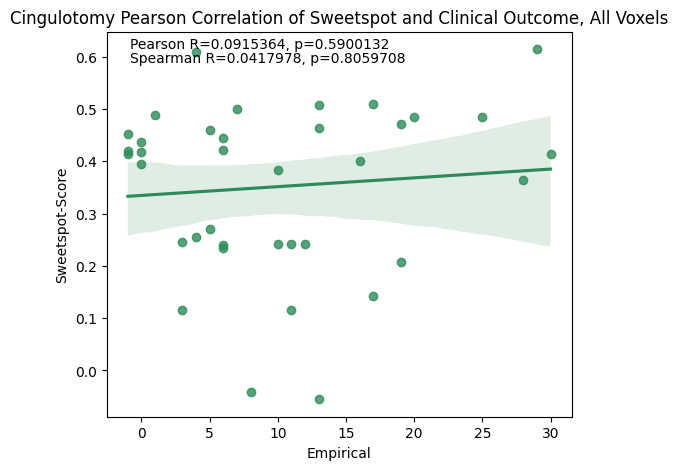

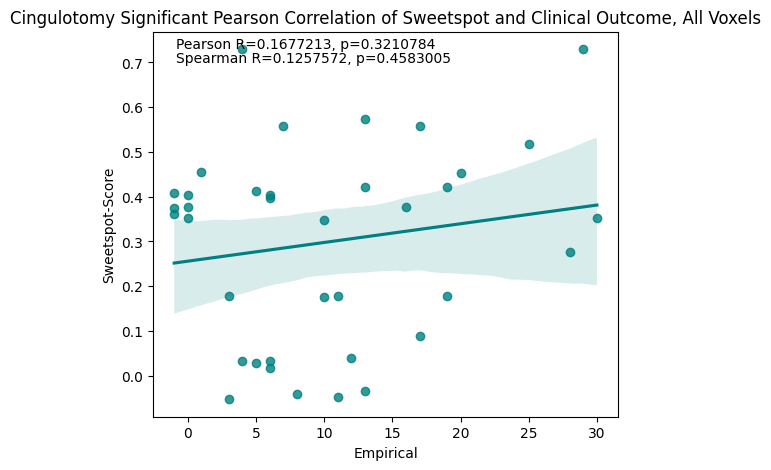

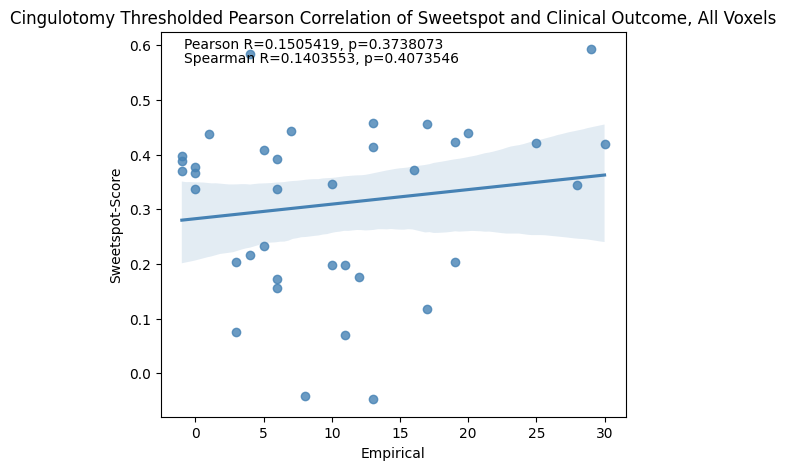

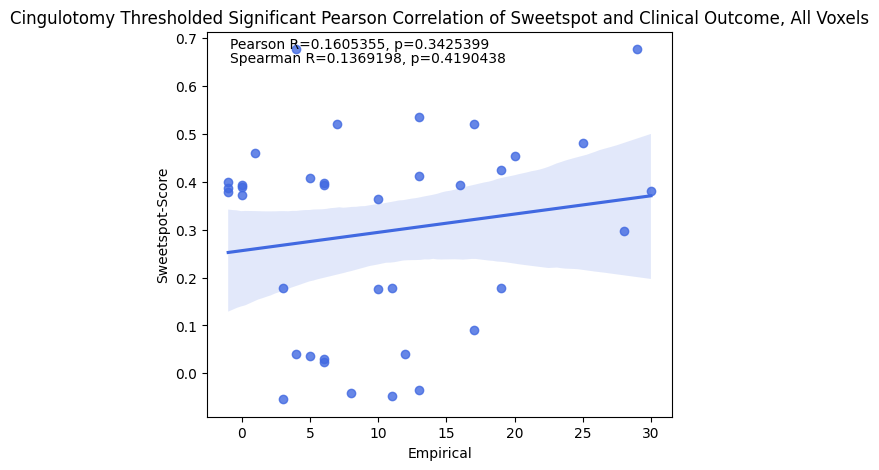

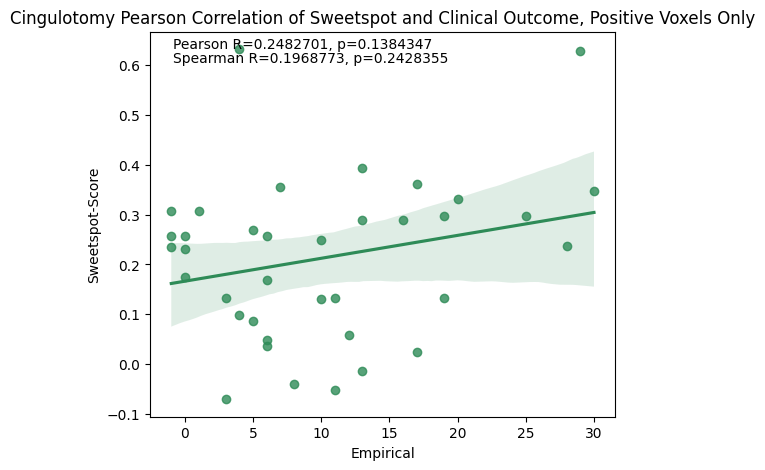

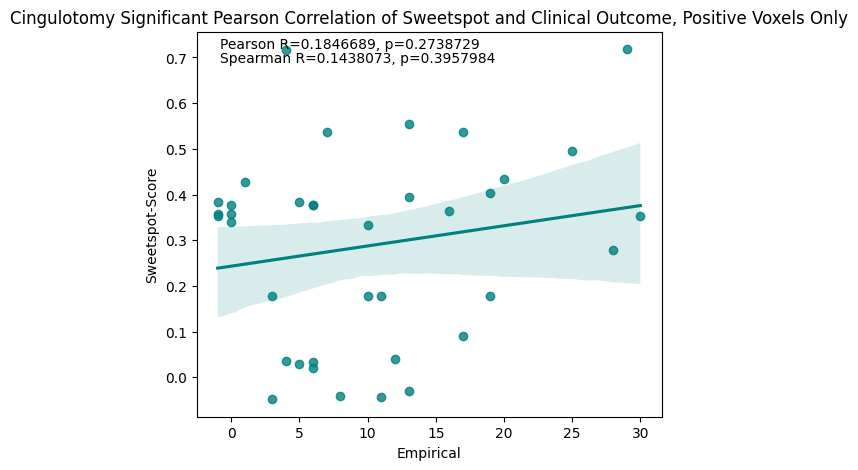

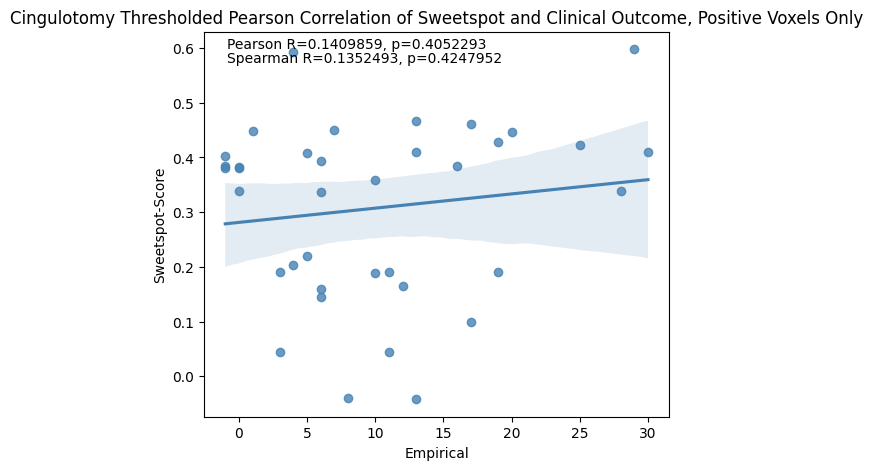

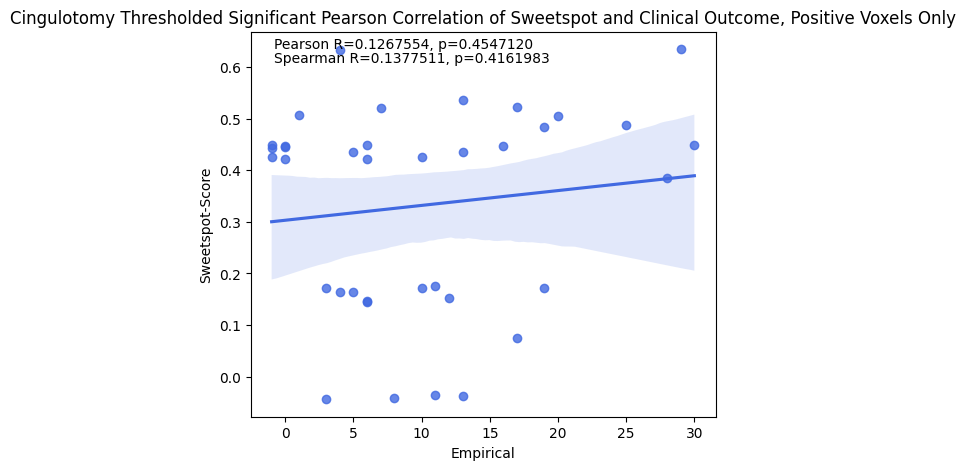

In [4]:
#pearson analysis for cingulotomies, absolute
def plot_pearson_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_pearson_analysis(cingulotomy_df, pearson_sweetspot_corr, 'Cingulotomy Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels', pearson_r_val, pearson_p_val, s_pearson_r_val, s_pearson_p_val, 'seagreen')
plot_pearson_analysis(cingulotomy_df, sig_pearson_sweetspot_corr, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_pearson_r_val, sig_pearson_p_val, s_sig_pearson_r_val, s_sig_pearson_p_val, 'teal')
plot_pearson_analysis(cingulotomy_df, thresholded_pearson_sweetspot_corr, 'Cingulotomy Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_pearson_r_val, thresholded_pearson_p_val, s_thresholded_pearson_r_val, s_thresholded_pearson_p_val, 'steelblue')
plot_pearson_analysis(cingulotomy_df, thresholded_sig_pearson_sweetspot_corr, 'Cingulotomy Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_sig_pearson_r_val, thresholded_sig_pearson_p_val, s_thresholded_sig_pearson_r_val, s_thresholded_sig_pearson_p_val, 'royalblue')

#positive
plot_pearson_analysis(cingulotomy_df, pos_pearson_sweetspot_corr, 'Cingulotomy Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_pearson_r_val, pos_pearson_p_val, pos_s_pearson_r_val, pos_s_pearson_p_val, 'seagreen')
plot_pearson_analysis(cingulotomy_df, pos_sig_pearson_sweetspot_corr, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_pearson_r_val, pos_sig_pearson_p_val, pos_s_sig_pearson_r_val, pos_s_sig_pearson_p_val, 'teal')
plot_pearson_analysis(cingulotomy_df, pos_thresholded_pearson_sweetspot_corr, 'Cingulotomy Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_pearson_r_val, pos_thresholded_pearson_p_val, pos_s_thresholded_pearson_r_val, pos_s_thresholded_pearson_p_val, 'steelblue')
plot_pearson_analysis(cingulotomy_df, pos_thresholded_sig_pearson_sweetspot_corr, 'Cingulotomy Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_pearson_r_val, pos_thresholded_sig_pearson_p_val, pos_s_thresholded_sig_pearson_r_val, pos_s_thresholded_sig_pearson_p_val, 'royalblue')

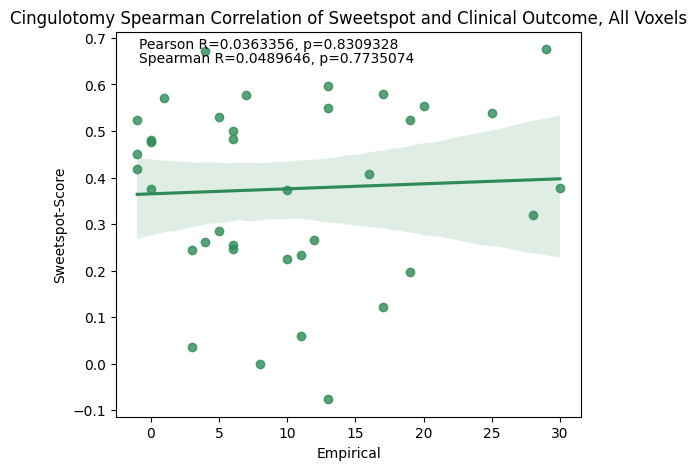

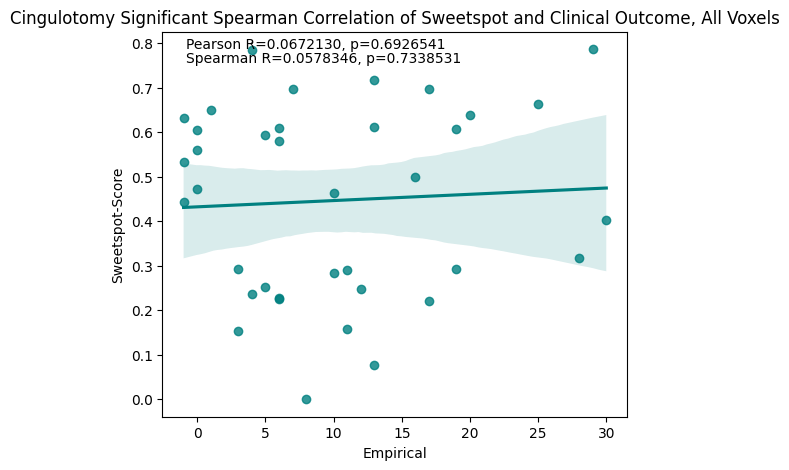

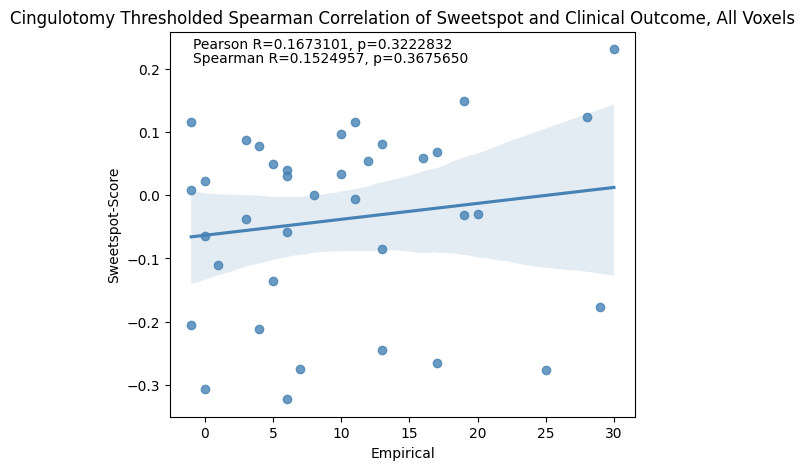

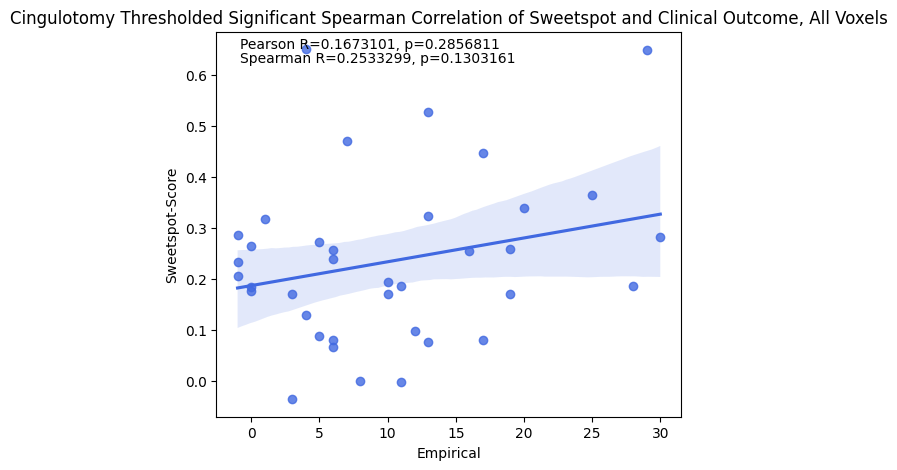

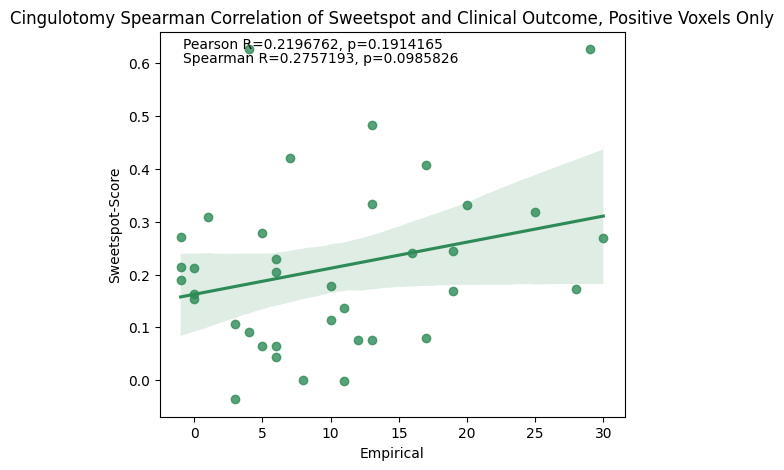

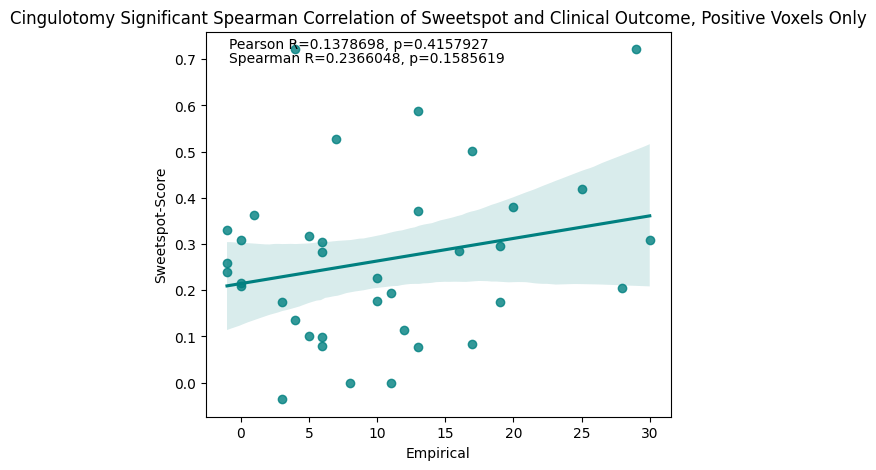

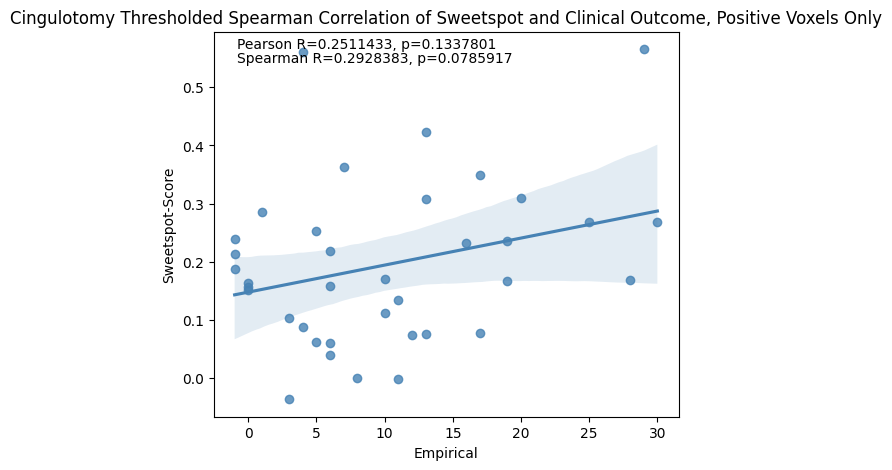

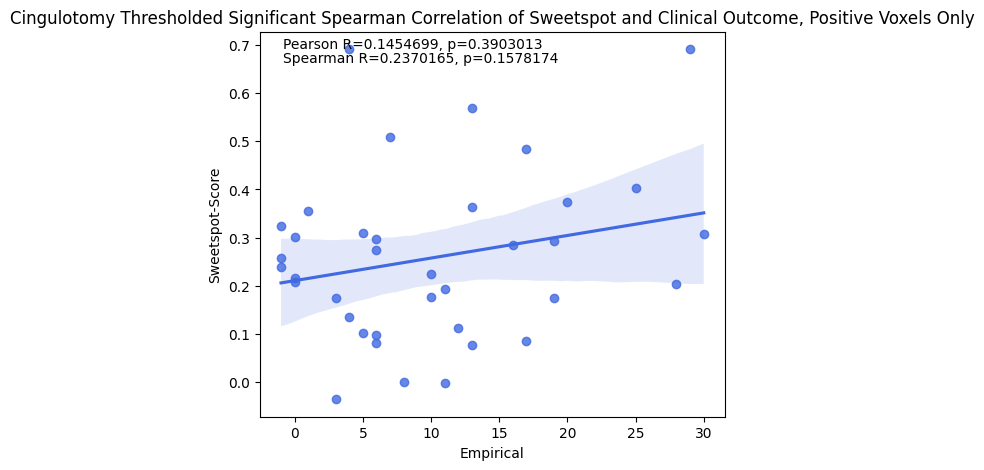

In [5]:
#spearman analysis for cingulotomies, absolute
def plot_spearman_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_spearman_analysis(cingulotomy_df, spearman_sweetspot_corr, 'Cingulotomy Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels', spearman_r_val, spearman_p_val, p_spearman_r_val, p_spearman_p_val, 'seagreen')
plot_spearman_analysis(cingulotomy_df, sig_spearman_sweetspot_corr, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_spearman_r_val, sig_spearman_p_val, p_sig_spearman_r_val, p_sig_spearman_p_val, 'teal')
plot_spearman_analysis(cingulotomy_df, thresholded_spearman_sweetspot_corr, 'Cingulotomy Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_spearman_p_val, p_thresholded_spearman_r_val, p_thresholded_spearman_p_val, 'steelblue')
plot_spearman_analysis(cingulotomy_df, thresholded_sig_spearman_sweetspot_corr, 'Cingulotomy Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_sig_spearman_p_val, p_thresholded_sig_spearman_r_val, p_thresholded_sig_spearman_p_val, 'royalblue')

#positive voxels only
plot_spearman_analysis(cingulotomy_df, pos_spearman_sweetspot_corr, 'Cingulotomy Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_spearman_r_val, pos_spearman_p_val, pos_p_spearman_r_val, pos_p_spearman_p_val, 'seagreen')
plot_spearman_analysis(cingulotomy_df, pos_sig_spearman_sweetspot_corr, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_spearman_r_val, pos_sig_spearman_p_val, pos_p_sig_spearman_r_val, pos_p_sig_spearman_p_val, 'teal')
plot_spearman_analysis(cingulotomy_df, pos_thresholded_spearman_sweetspot_corr, 'Cingulotomy Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_spearman_r_val, pos_thresholded_spearman_p_val, pos_p_thresholded_spearman_r_val, pos_p_thresholded_spearman_p_val, 'steelblue')
plot_spearman_analysis(cingulotomy_df, pos_thresholded_sig_spearman_sweetspot_corr, 'Cingulotomy Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_spearman_r_val, pos_thresholded_sig_spearman_p_val, pos_p_thresholded_sig_spearman_r_val, pos_p_thresholded_sig_spearman_p_val, 'royalblue')

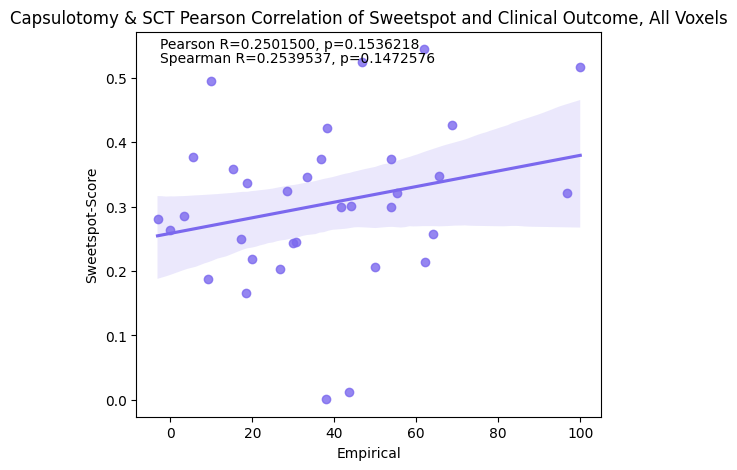

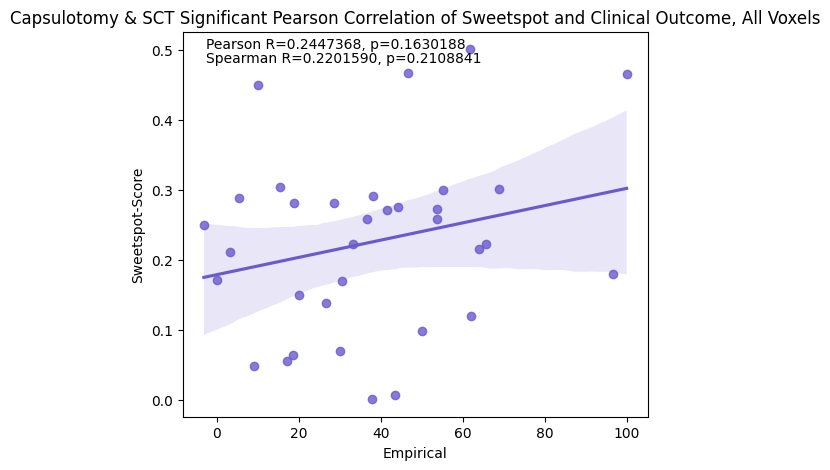

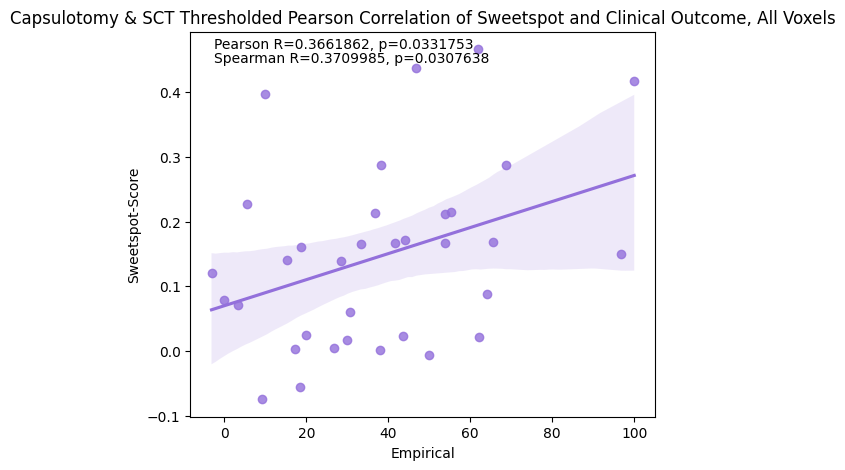

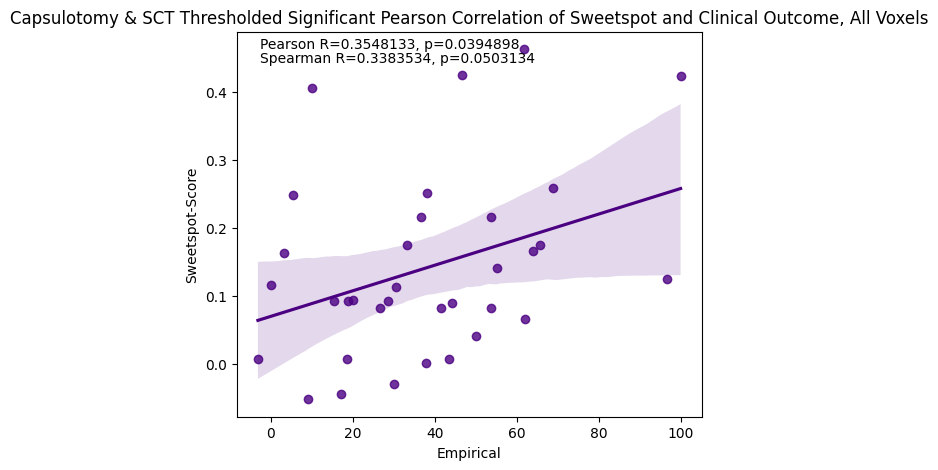

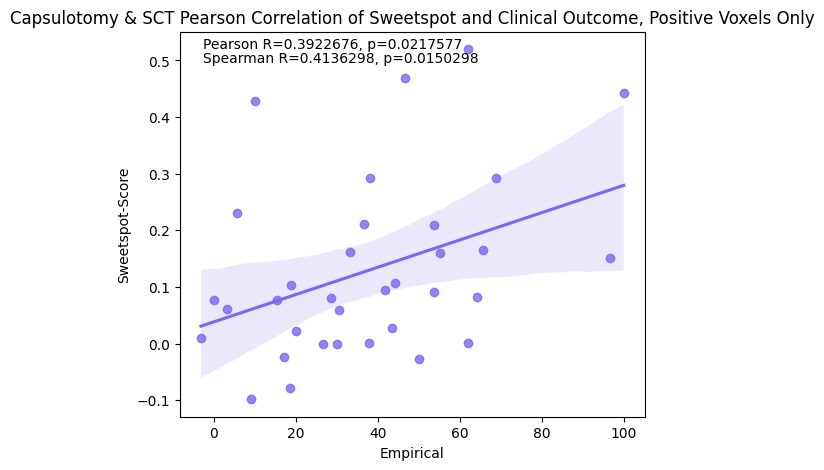

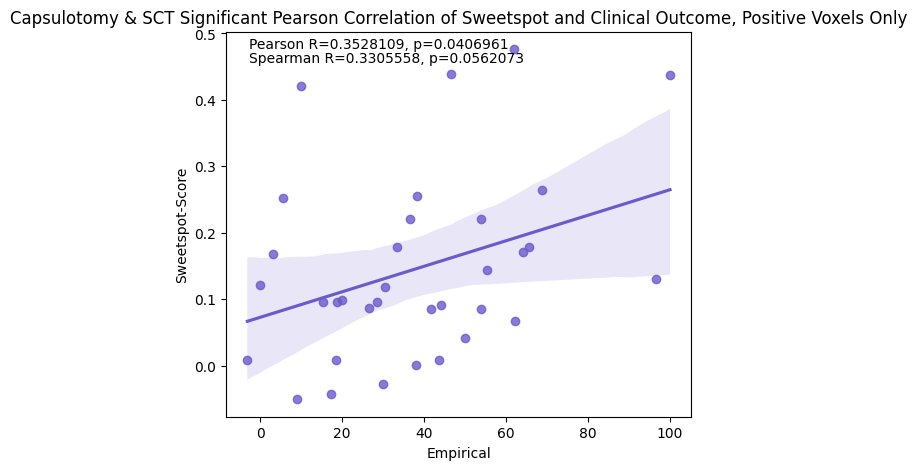

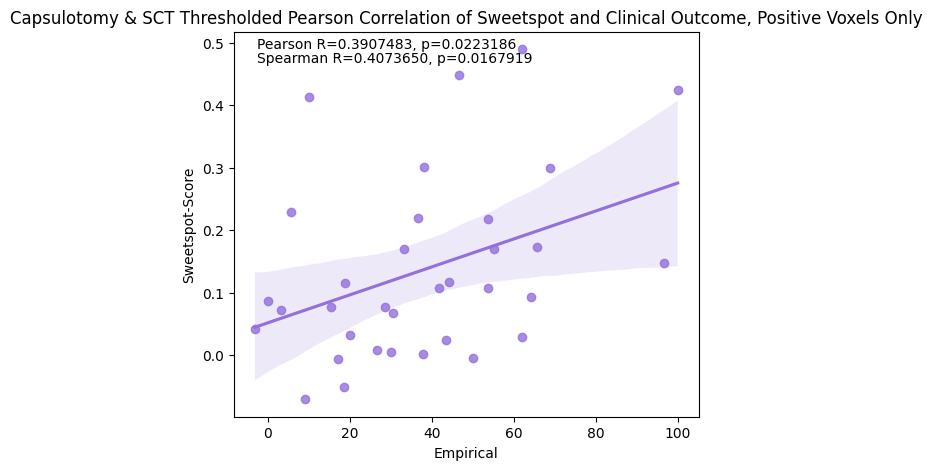

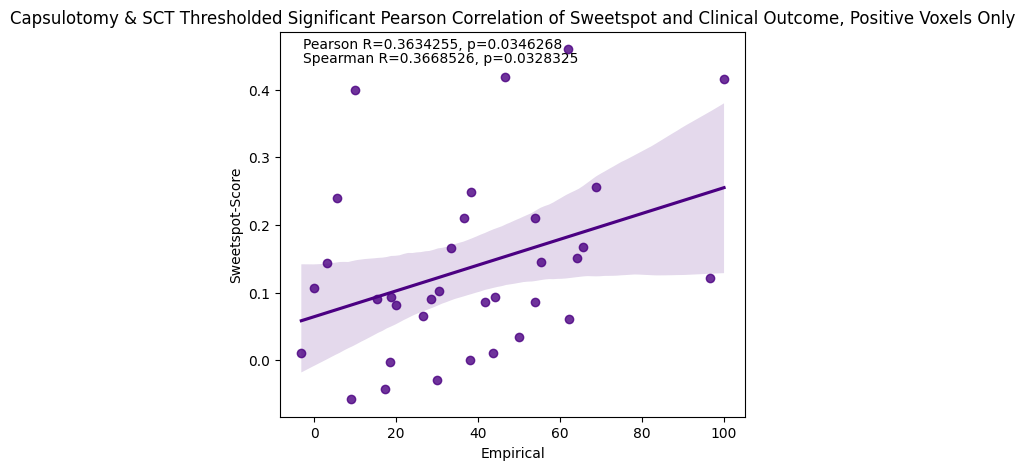

In [11]:
#pearson analysis for capsulotomies and scts, relative
def plot_pearson_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_pearson_analysis(cap_sct_df, pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels', pearson_r_val, pearson_p_val, s_pearson_r_val, s_pearson_p_val, 'mediumslateblue')
plot_pearson_analysis(cap_sct_df, sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_pearson_r_val, sig_pearson_p_val, s_sig_pearson_r_val, s_sig_pearson_p_val, 'slateblue')
plot_pearson_analysis(cap_sct_df, thresholded_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_pearson_r_val, thresholded_pearson_p_val, s_thresholded_pearson_r_val, s_thresholded_pearson_p_val, 'mediumpurple')
plot_pearson_analysis(cap_sct_df, thresholded_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_sig_pearson_r_val, thresholded_sig_pearson_p_val, s_thresholded_sig_pearson_r_val, s_thresholded_sig_pearson_p_val, 'indigo')

#positive
plot_pearson_analysis(cap_sct_df, pos_pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_pearson_r_val, pos_pearson_p_val, pos_s_pearson_r_val, pos_s_pearson_p_val, 'mediumslateblue')
plot_pearson_analysis(cap_sct_df, pos_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_pearson_r_val, pos_sig_pearson_p_val, pos_s_sig_pearson_r_val, pos_s_sig_pearson_p_val, 'slateblue')
plot_pearson_analysis(cap_sct_df, pos_thresholded_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_pearson_r_val, pos_thresholded_pearson_p_val, pos_s_thresholded_pearson_r_val, pos_s_thresholded_pearson_p_val, 'mediumpurple')
plot_pearson_analysis(cap_sct_df, pos_thresholded_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_pearson_r_val, pos_thresholded_sig_pearson_p_val, pos_s_thresholded_sig_pearson_r_val, pos_s_thresholded_sig_pearson_p_val, 'indigo')

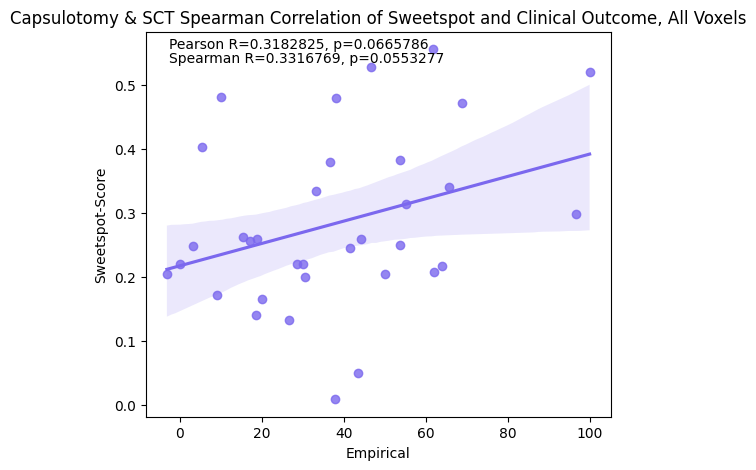

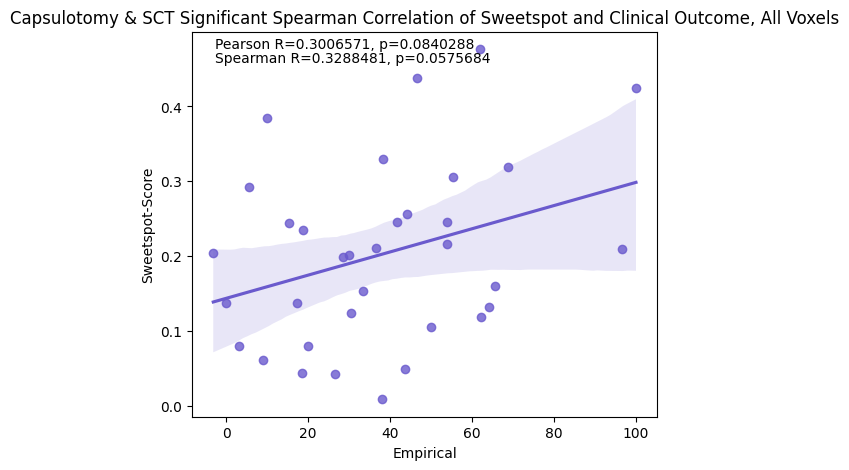

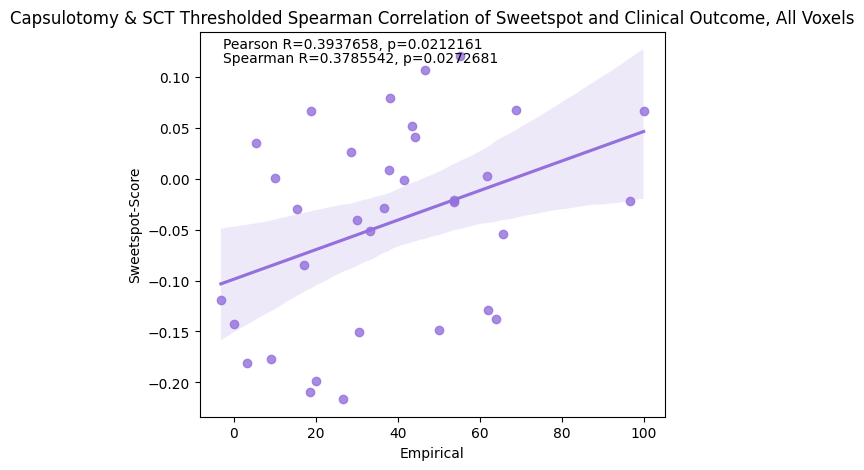

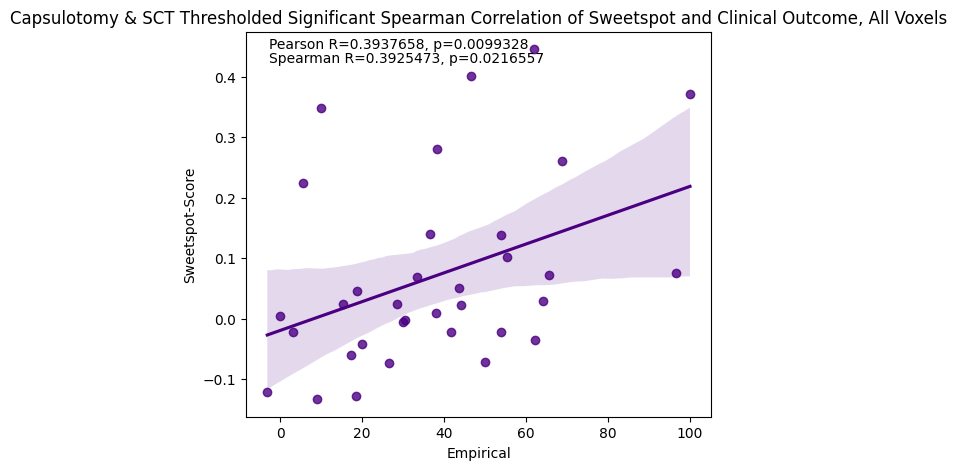

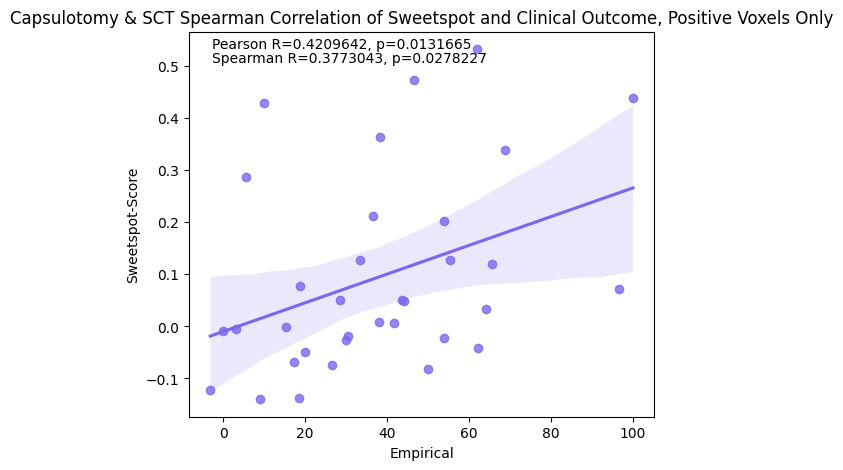

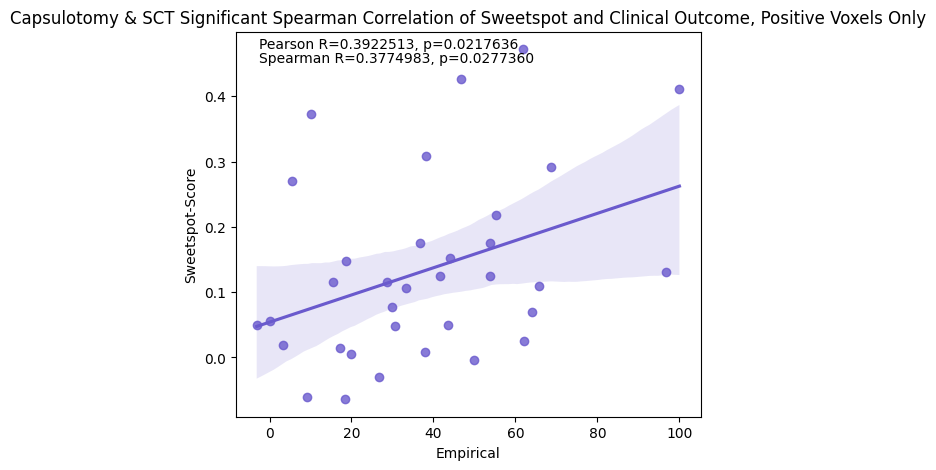

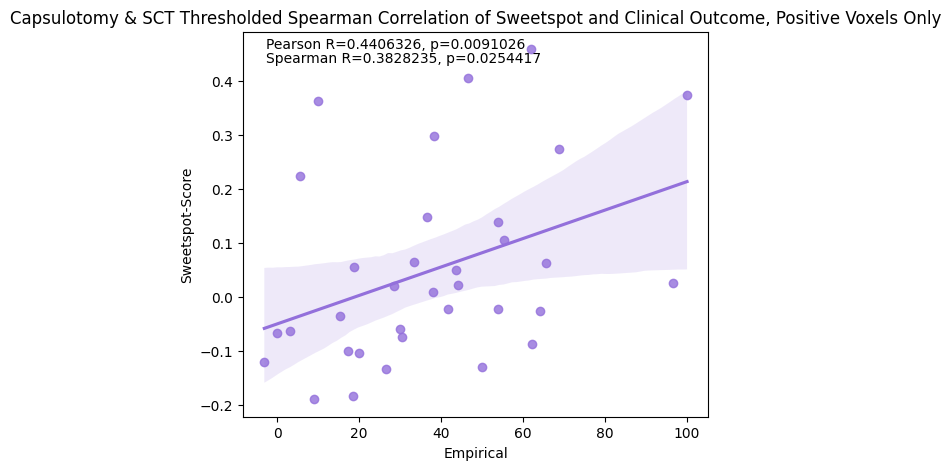

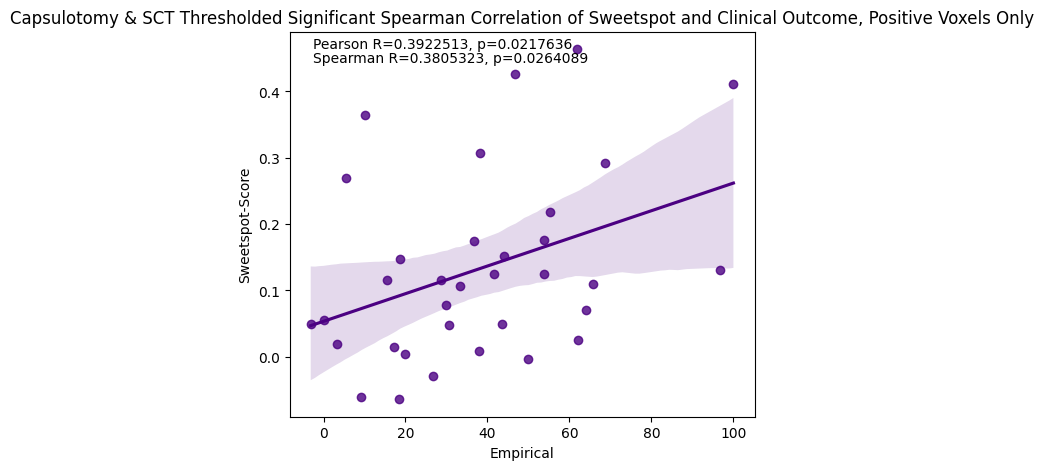

In [12]:
#spearman analysis for capsulotomies and SCTs, relative
def plot_spearman_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_spearman_analysis(cap_sct_df, spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels', spearman_r_val, spearman_p_val, p_spearman_r_val, p_spearman_p_val, 'mediumslateblue')
plot_spearman_analysis(cap_sct_df, sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_spearman_r_val, sig_spearman_p_val, p_sig_spearman_r_val, p_sig_spearman_p_val, 'slateblue')
plot_spearman_analysis(cap_sct_df, thresholded_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_spearman_p_val, p_thresholded_spearman_r_val, p_thresholded_spearman_p_val, 'mediumpurple')
plot_spearman_analysis(cap_sct_df, thresholded_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_sig_spearman_p_val, p_thresholded_sig_spearman_r_val, p_thresholded_sig_spearman_p_val, 'indigo')

#positive voxels only
plot_spearman_analysis(cap_sct_df, pos_spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_spearman_r_val, pos_spearman_p_val, pos_p_spearman_r_val, pos_p_spearman_p_val, 'mediumslateblue')
plot_spearman_analysis(cap_sct_df, pos_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_spearman_r_val, pos_sig_spearman_p_val, pos_p_sig_spearman_r_val, pos_p_sig_spearman_p_val, 'slateblue')
plot_spearman_analysis(cap_sct_df, pos_thresholded_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_spearman_r_val, pos_thresholded_spearman_p_val, pos_p_thresholded_spearman_r_val, pos_p_thresholded_spearman_p_val, 'mediumpurple')
plot_spearman_analysis(cap_sct_df, pos_thresholded_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_spearman_r_val, pos_thresholded_sig_spearman_p_val, pos_p_thresholded_sig_spearman_r_val, pos_p_thresholded_sig_spearman_p_val, 'indigo')

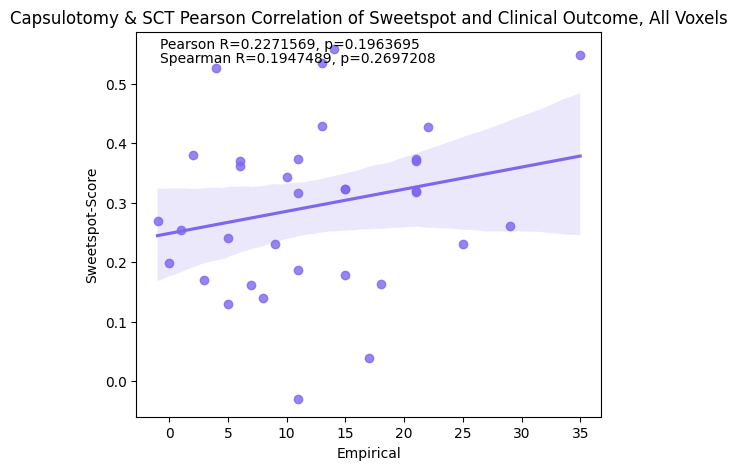

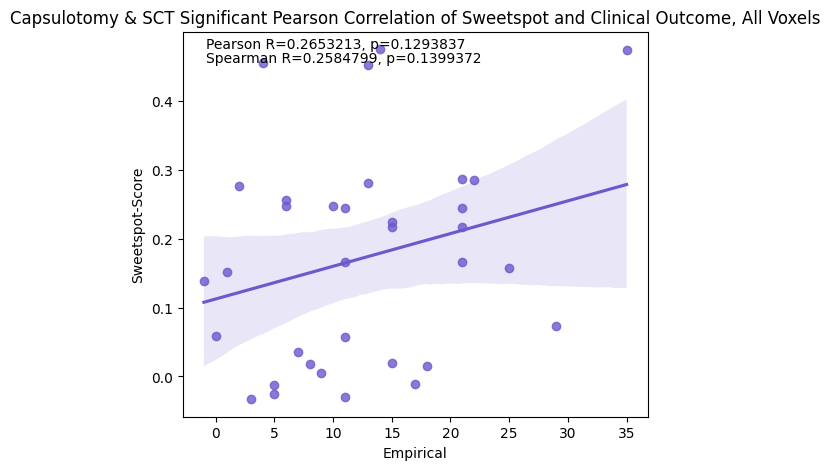

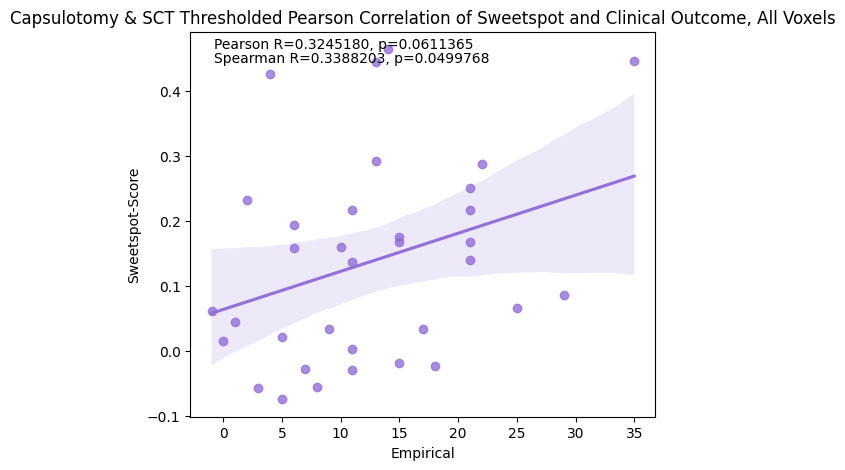

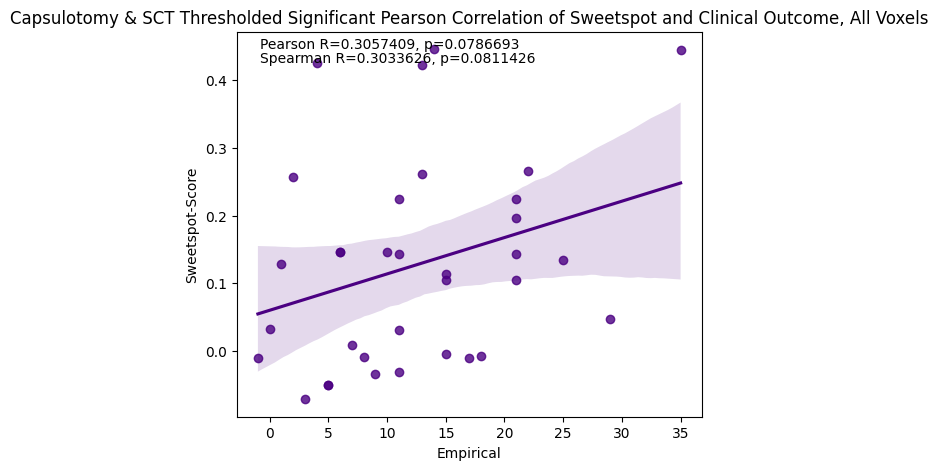

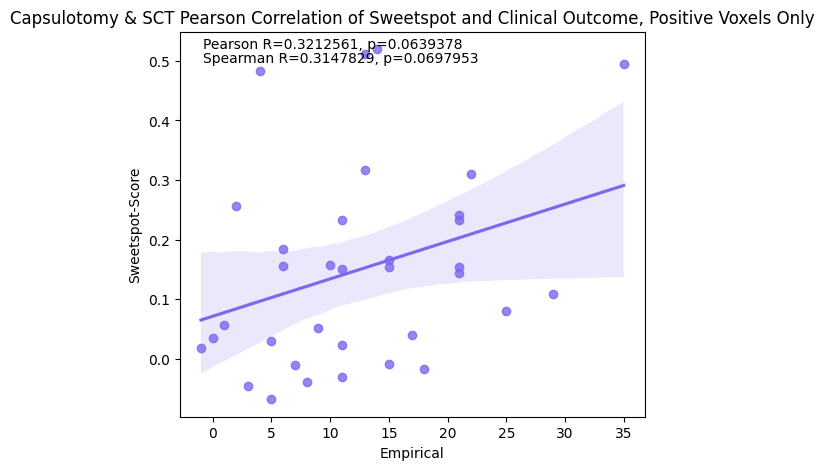

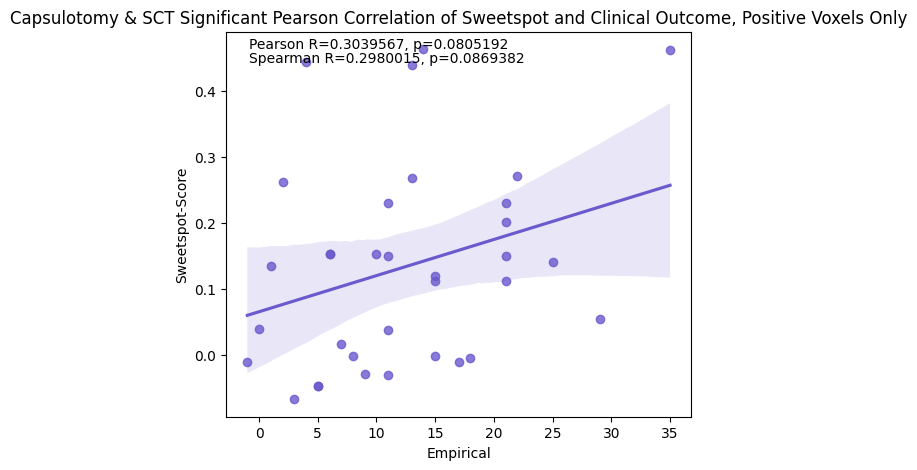

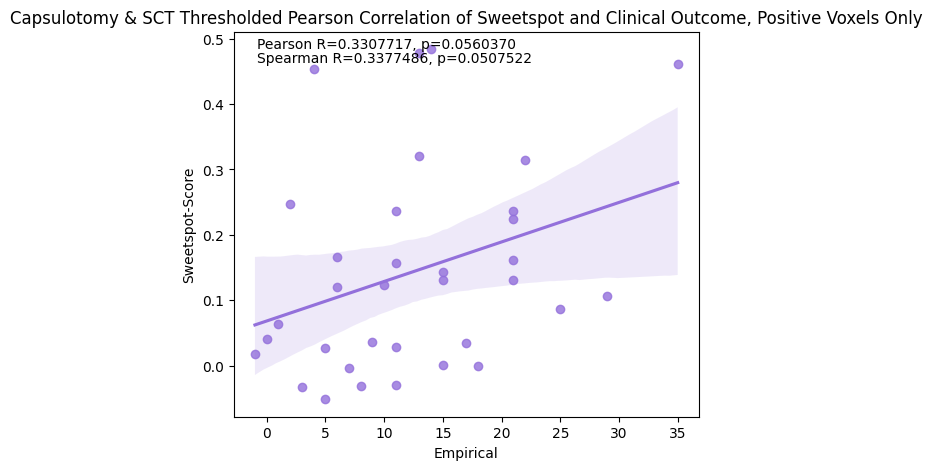

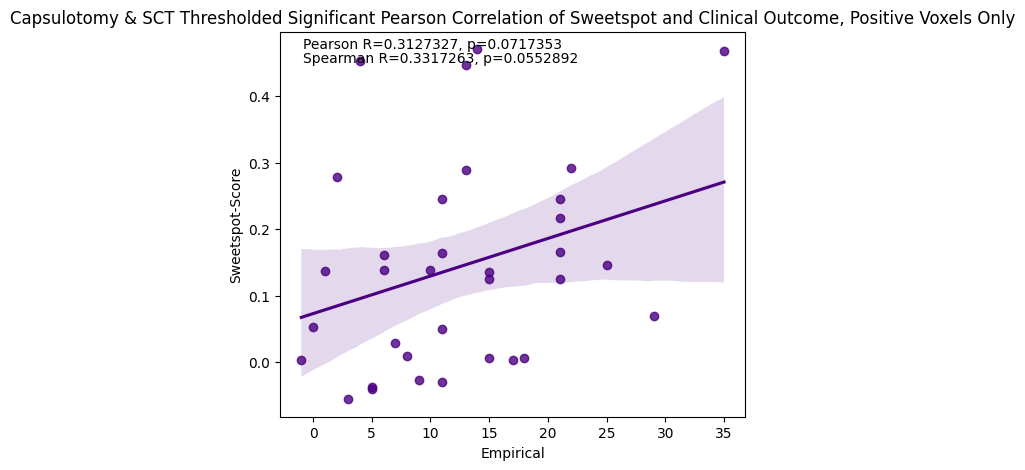

In [15]:
#pearson analysis for capsulotomies and scts, absolute
def plot_pearson_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_pearson_analysis(cap_sct_df, pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels', pearson_r_val, pearson_p_val, s_pearson_r_val, s_pearson_p_val, 'mediumslateblue')
plot_pearson_analysis(cap_sct_df, sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_pearson_r_val, sig_pearson_p_val, s_sig_pearson_r_val, s_sig_pearson_p_val, 'slateblue')
plot_pearson_analysis(cap_sct_df, thresholded_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_pearson_r_val, thresholded_pearson_p_val, s_thresholded_pearson_r_val, s_thresholded_pearson_p_val, 'mediumpurple')
plot_pearson_analysis(cap_sct_df, thresholded_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_sig_pearson_r_val, thresholded_sig_pearson_p_val, s_thresholded_sig_pearson_r_val, s_thresholded_sig_pearson_p_val, 'indigo')

#positive
plot_pearson_analysis(cap_sct_df, pos_pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_pearson_r_val, pos_pearson_p_val, pos_s_pearson_r_val, pos_s_pearson_p_val, 'mediumslateblue')
plot_pearson_analysis(cap_sct_df, pos_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_pearson_r_val, pos_sig_pearson_p_val, pos_s_sig_pearson_r_val, pos_s_sig_pearson_p_val, 'slateblue')
plot_pearson_analysis(cap_sct_df, pos_thresholded_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_pearson_r_val, pos_thresholded_pearson_p_val, pos_s_thresholded_pearson_r_val, pos_s_thresholded_pearson_p_val, 'mediumpurple')
plot_pearson_analysis(cap_sct_df, pos_thresholded_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_pearson_r_val, pos_thresholded_sig_pearson_p_val, pos_s_thresholded_sig_pearson_r_val, pos_s_thresholded_sig_pearson_p_val, 'indigo')

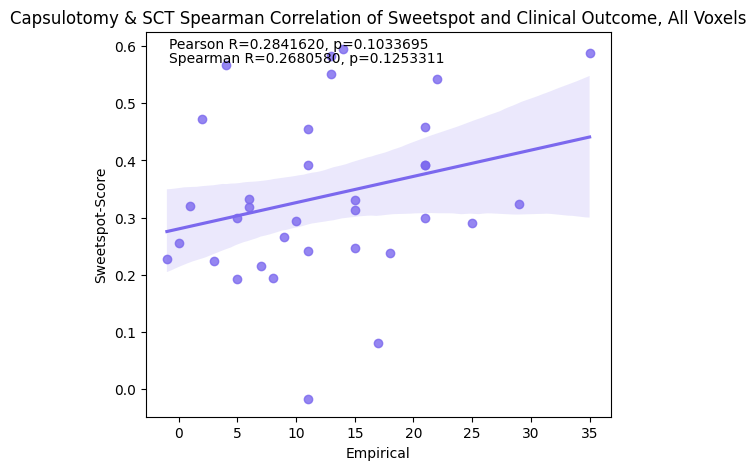

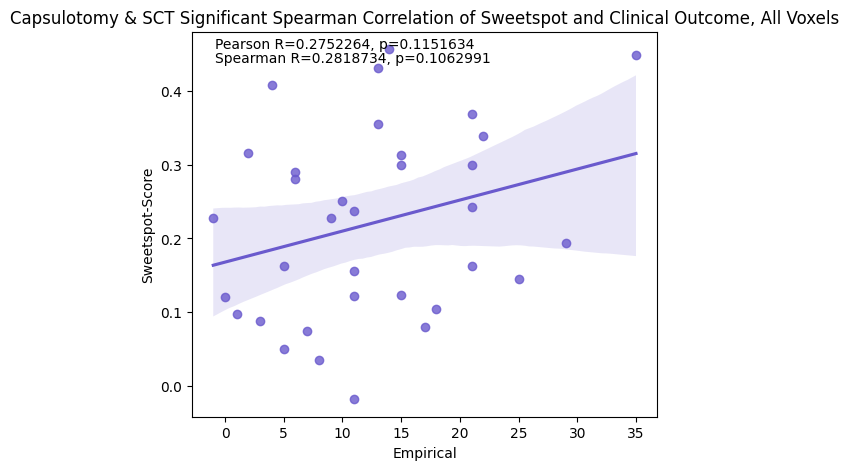

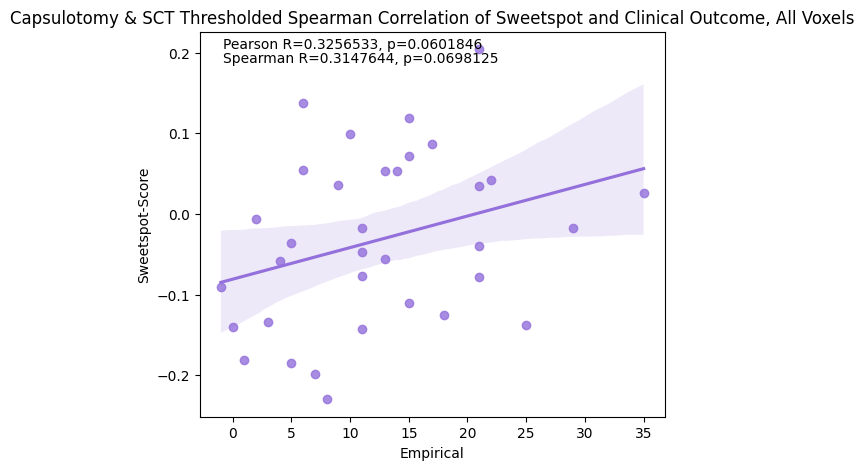

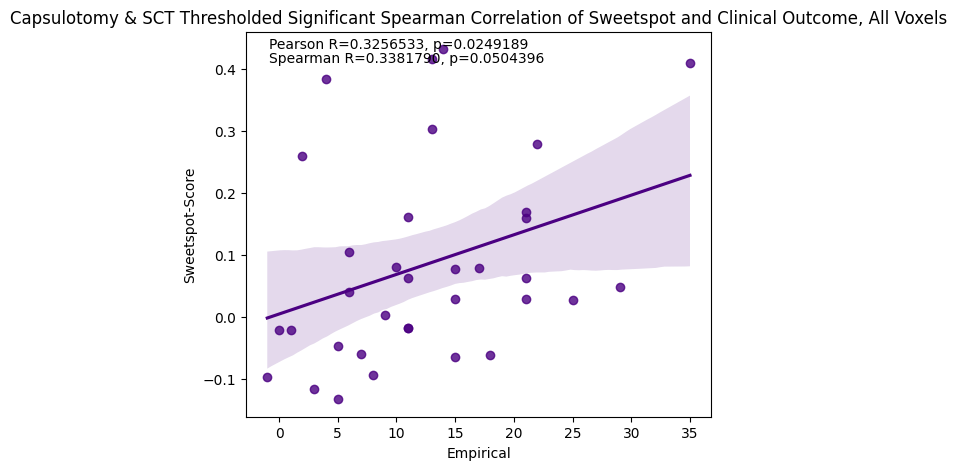

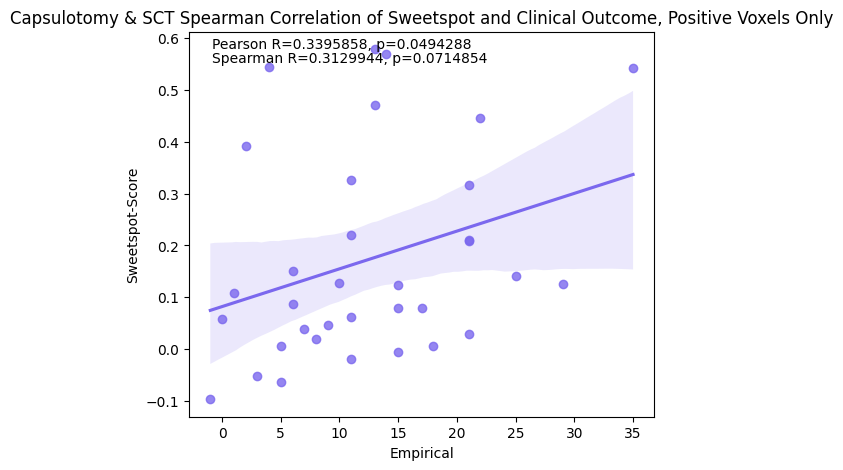

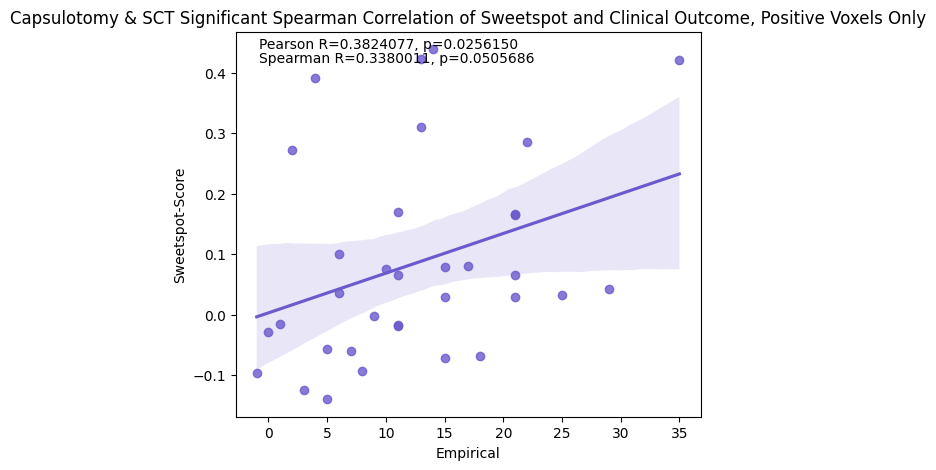

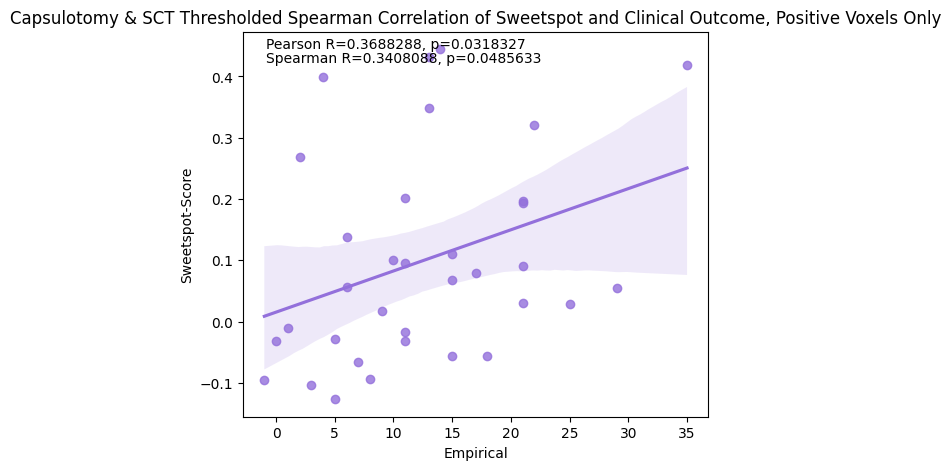

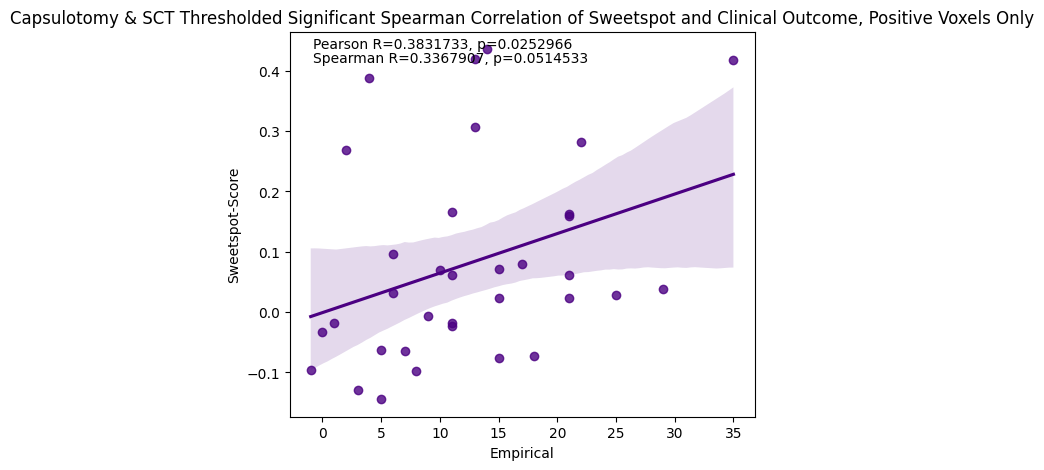

In [16]:
#spearman analysis for capsulotomies and SCTs, absolute
def plot_spearman_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

plot_spearman_analysis(cap_sct_df, spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels', spearman_r_val, spearman_p_val, p_spearman_r_val, p_spearman_p_val, 'mediumslateblue')
plot_spearman_analysis(cap_sct_df, sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',sig_spearman_r_val, sig_spearman_p_val, p_sig_spearman_r_val, p_sig_spearman_p_val, 'slateblue')
plot_spearman_analysis(cap_sct_df, thresholded_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_spearman_p_val, p_thresholded_spearman_r_val, p_thresholded_spearman_p_val, 'mediumpurple')
plot_spearman_analysis(cap_sct_df, thresholded_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, All Voxels',thresholded_spearman_r_val, thresholded_sig_spearman_p_val, p_thresholded_sig_spearman_r_val, p_thresholded_sig_spearman_p_val, 'indigo')

#positive voxels only
plot_spearman_analysis(cap_sct_df, pos_spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', pos_spearman_r_val, pos_spearman_p_val, pos_p_spearman_r_val, pos_p_spearman_p_val, 'mediumslateblue')
plot_spearman_analysis(cap_sct_df, pos_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_sig_spearman_r_val, pos_sig_spearman_p_val, pos_p_sig_spearman_r_val, pos_p_sig_spearman_p_val, 'slateblue')
plot_spearman_analysis(cap_sct_df, pos_thresholded_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_spearman_r_val, pos_thresholded_spearman_p_val, pos_p_thresholded_spearman_r_val, pos_p_thresholded_spearman_p_val, 'mediumpurple')
plot_spearman_analysis(cap_sct_df, pos_thresholded_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Thresholded Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_thresholded_sig_spearman_r_val, pos_thresholded_sig_spearman_p_val, pos_p_thresholded_sig_spearman_r_val, pos_p_thresholded_sig_spearman_p_val, 'indigo')